<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Machine Learning with PyTorch for Developers</h1>
<h1>Unsupervised Learning</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

import sklearn
from sklearn import datasets
from sklearn.cluster import DBSCAN

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.13.2
IPython version      : 9.0.0

Compiler    : Clang 16.0.0 (clang-1600.0.26.6)
OS          : Darwin
Release     : 24.3.0
Machine     : arm64
Processor   : arm
CPU cores   : 16
Architecture: 64bit

Git hash: 9fc8d0140a8bc745a378db69347b7f8d00e6f884

torch     : 2.6.0
pandas    : 2.2.3
sklearn   : 1.6.1
matplotlib: 3.10.1
numpy     : 2.2.3
seaborn   : 0.13.2
watermark : 2.5.0



Load default figure style

In [3]:
plt.style.use('d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Principal Component Analysis

We'll illustrate the PCA algorithm using a simple dataset of Happiness as a function of Income level:

In [4]:
data = pd.read_csv('data/income_data.csv', index_col=0)

The clear linear relationship makes it easy to see exactly what is being captured by the PCA algorithm

Text(0, 0.5, 'Happiness')

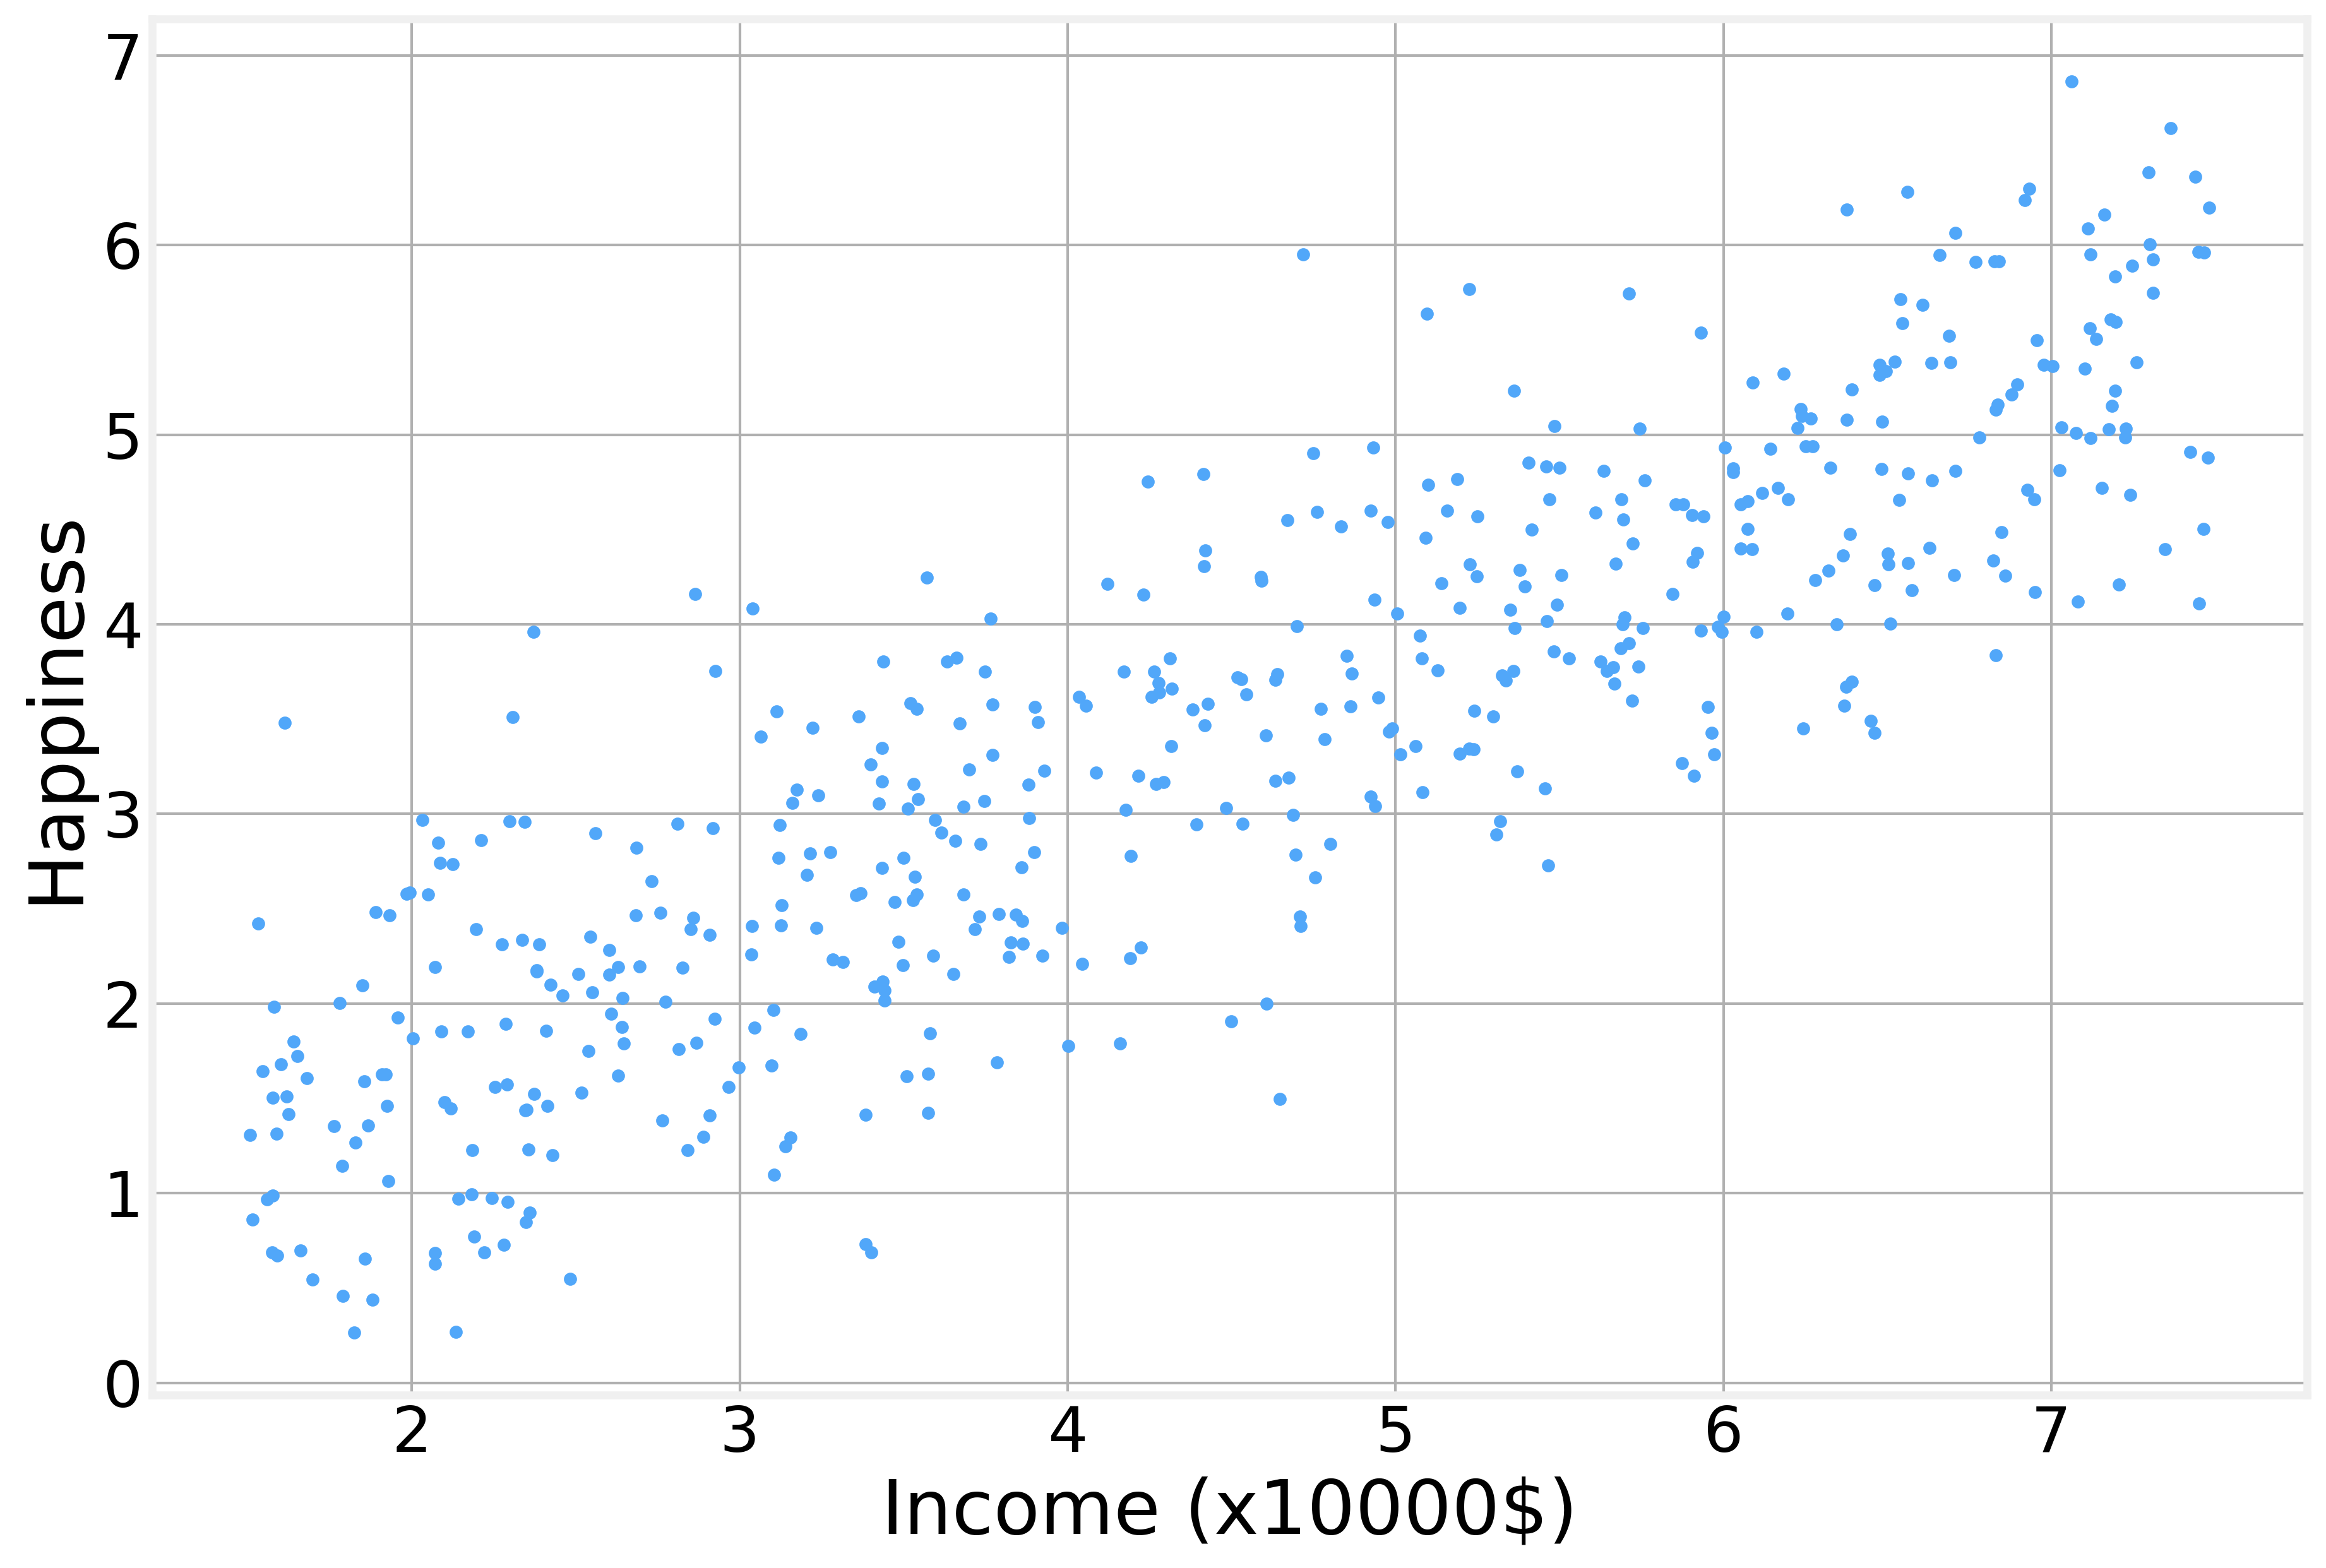

In [5]:
ax = data.plot(x='income', y='happiness', kind='scatter')
ax.set_xlabel('Income (x10000$)')
ax.set_ylabel('Happiness')


Next we implement our PCA transformation:

In [6]:
def pca_transform(df, n_components=2):
    # Convert DataFrame to tensor
    X = torch.tensor(df.values, dtype=torch.float32)
    
    # Center the data
    X_centered = X - X.mean(dim=0)
    
    # Compute covariance matrix
    cov_matrix = (X_centered.T @ X_centered) / (X_centered.shape[0] - 1)
    
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = torch.linalg.eigh(cov_matrix)
    
    # Sort in descending order
    sorted_indices = torch.argsort(eigenvalues, descending=True)
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    
    # Take top components
    top_eigenvectors = eigenvectors[:, :n_components]
    
    # Project data
    X_pca = X_centered @ top_eigenvectors
    
    # Calculate explained variance
    explained_variance_ratio = eigenvalues[:n_components] / eigenvalues.sum()
    
    return X_pca, explained_variance_ratio, top_eigenvectors

And apply it to our dataset

In [7]:
data_pca, explained_variance, top_eigenvectors = pca_transform(data, n_components=2)

`data_pca` is the original data plotted in the Principal Component space

Text(145.99999999999994, 0.5, 'Principal Component 2')

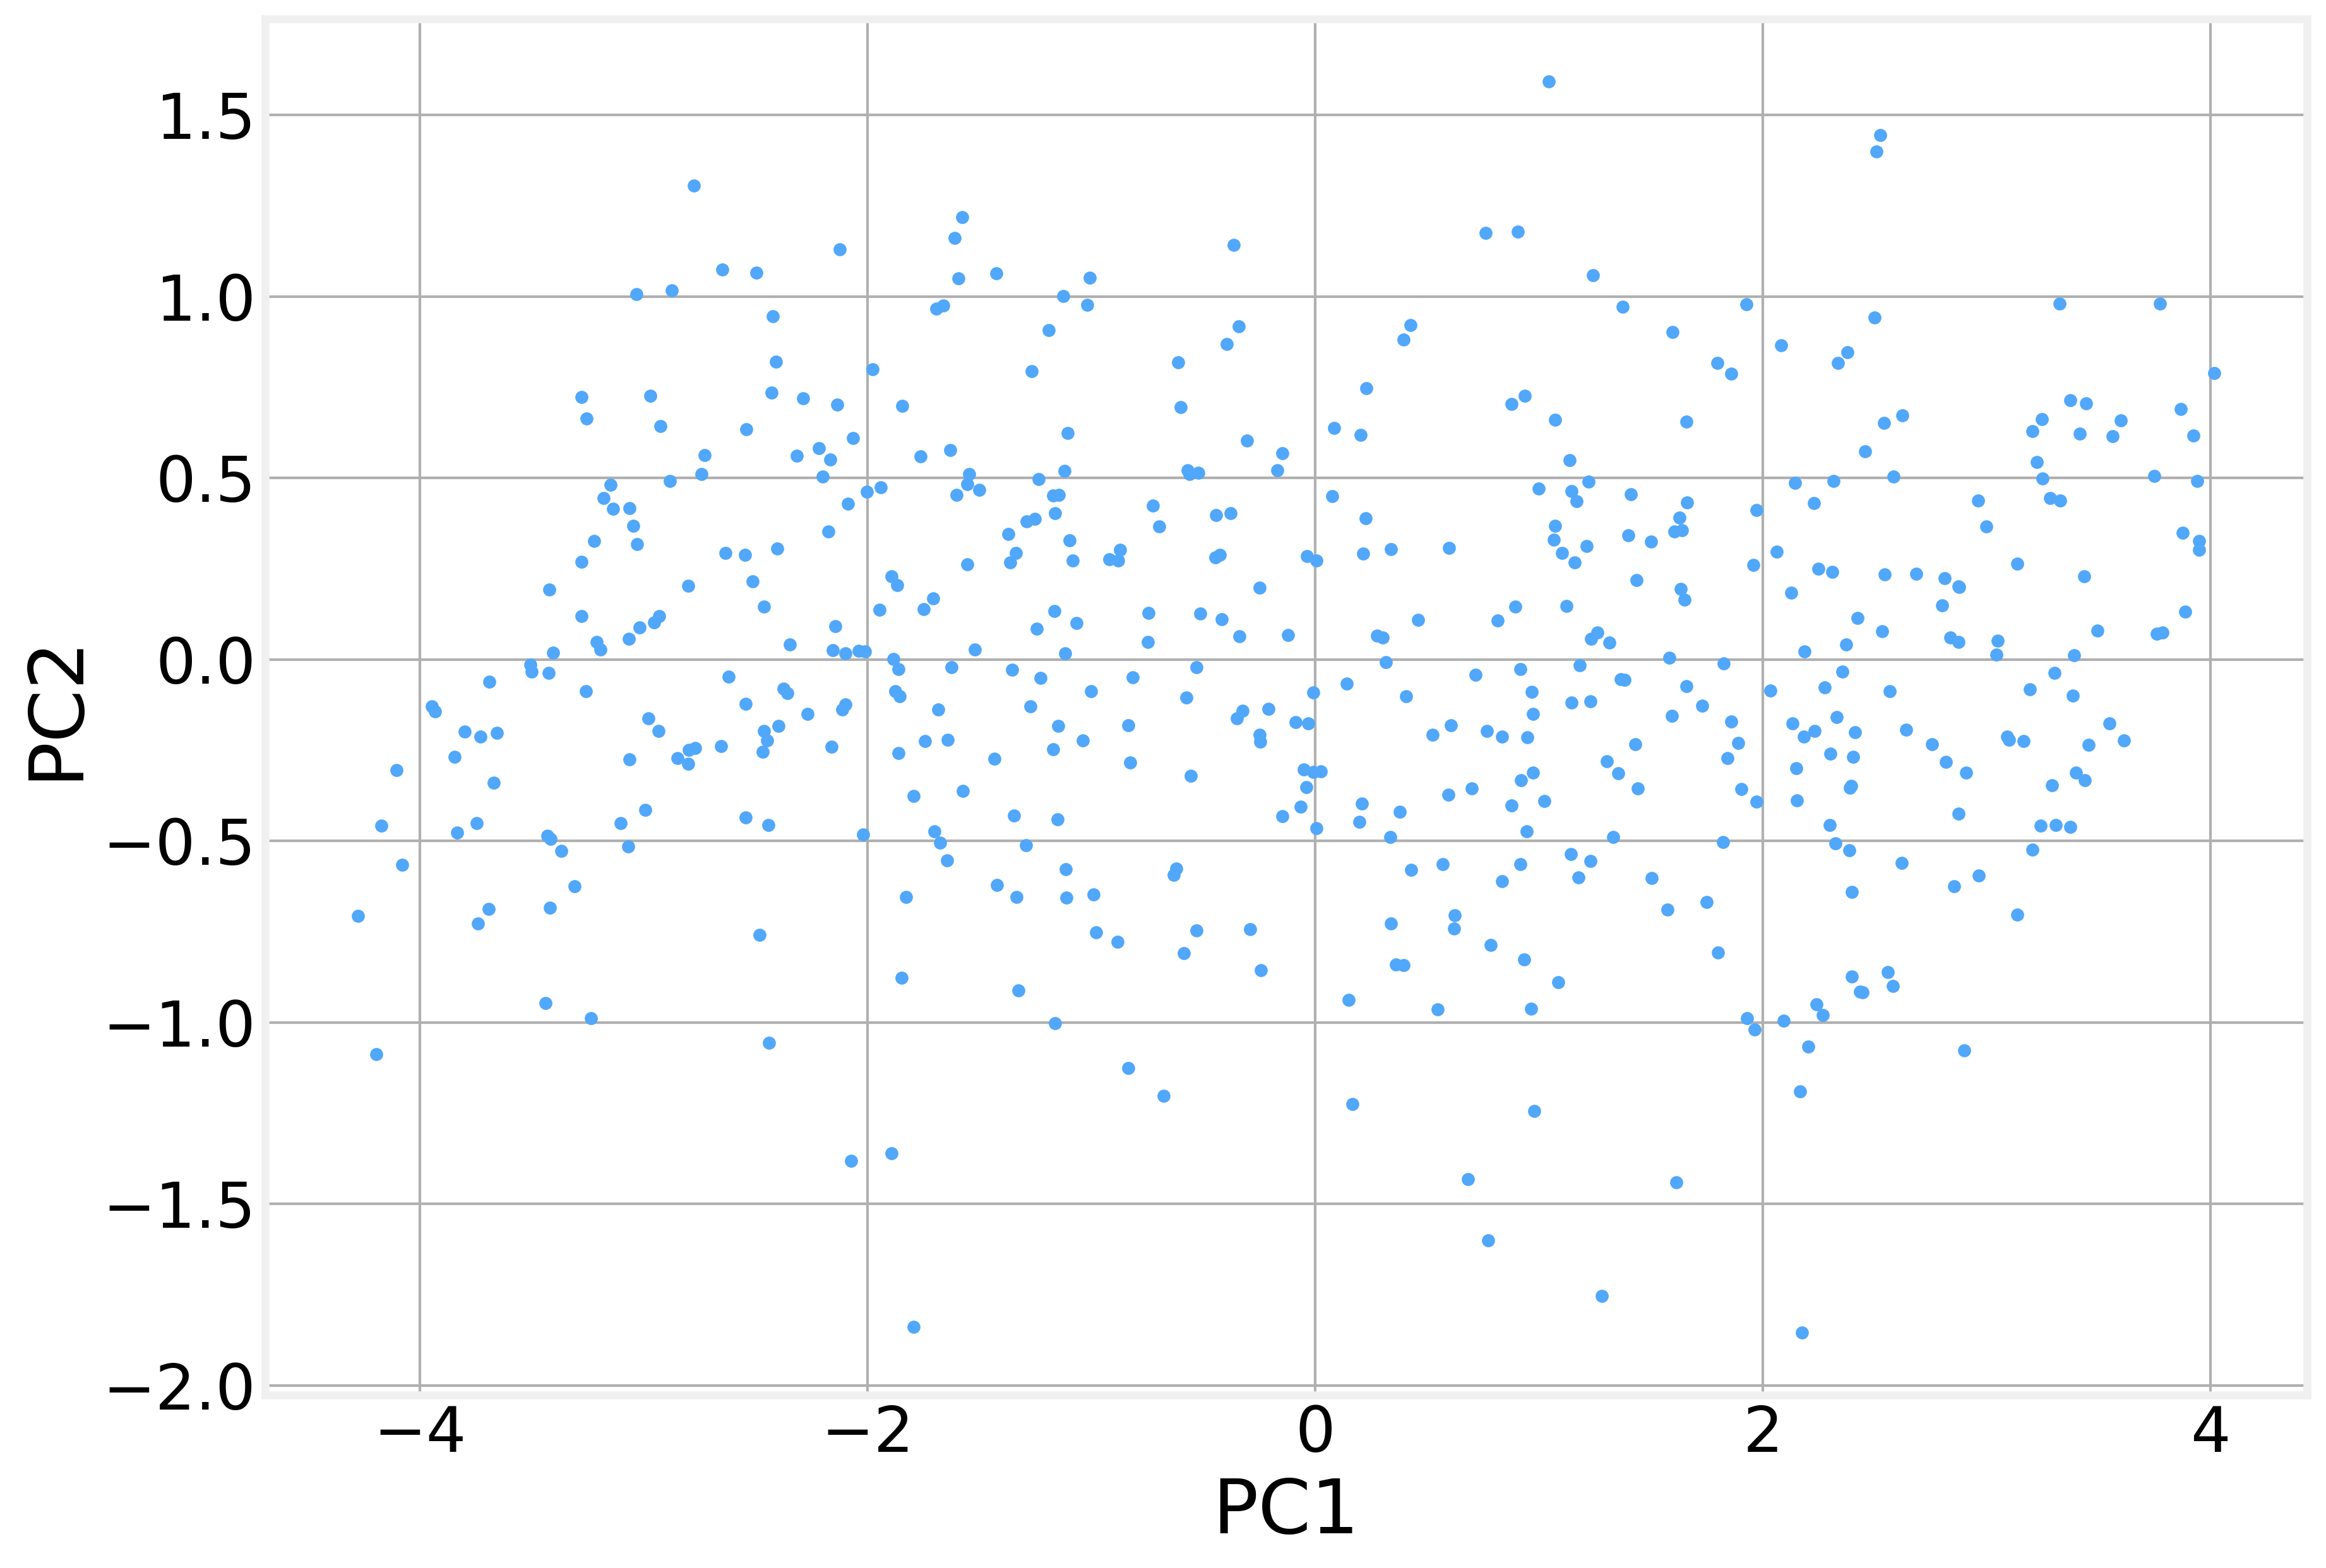

In [8]:
data_pca = pd.DataFrame(data_pca.numpy(), columns=['PC1', 'PC2'])
data_pca.plot(x='PC1', y='PC2', kind='scatter')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')

Text(4.587964057922363, 3.24165940284729, 'PC2')

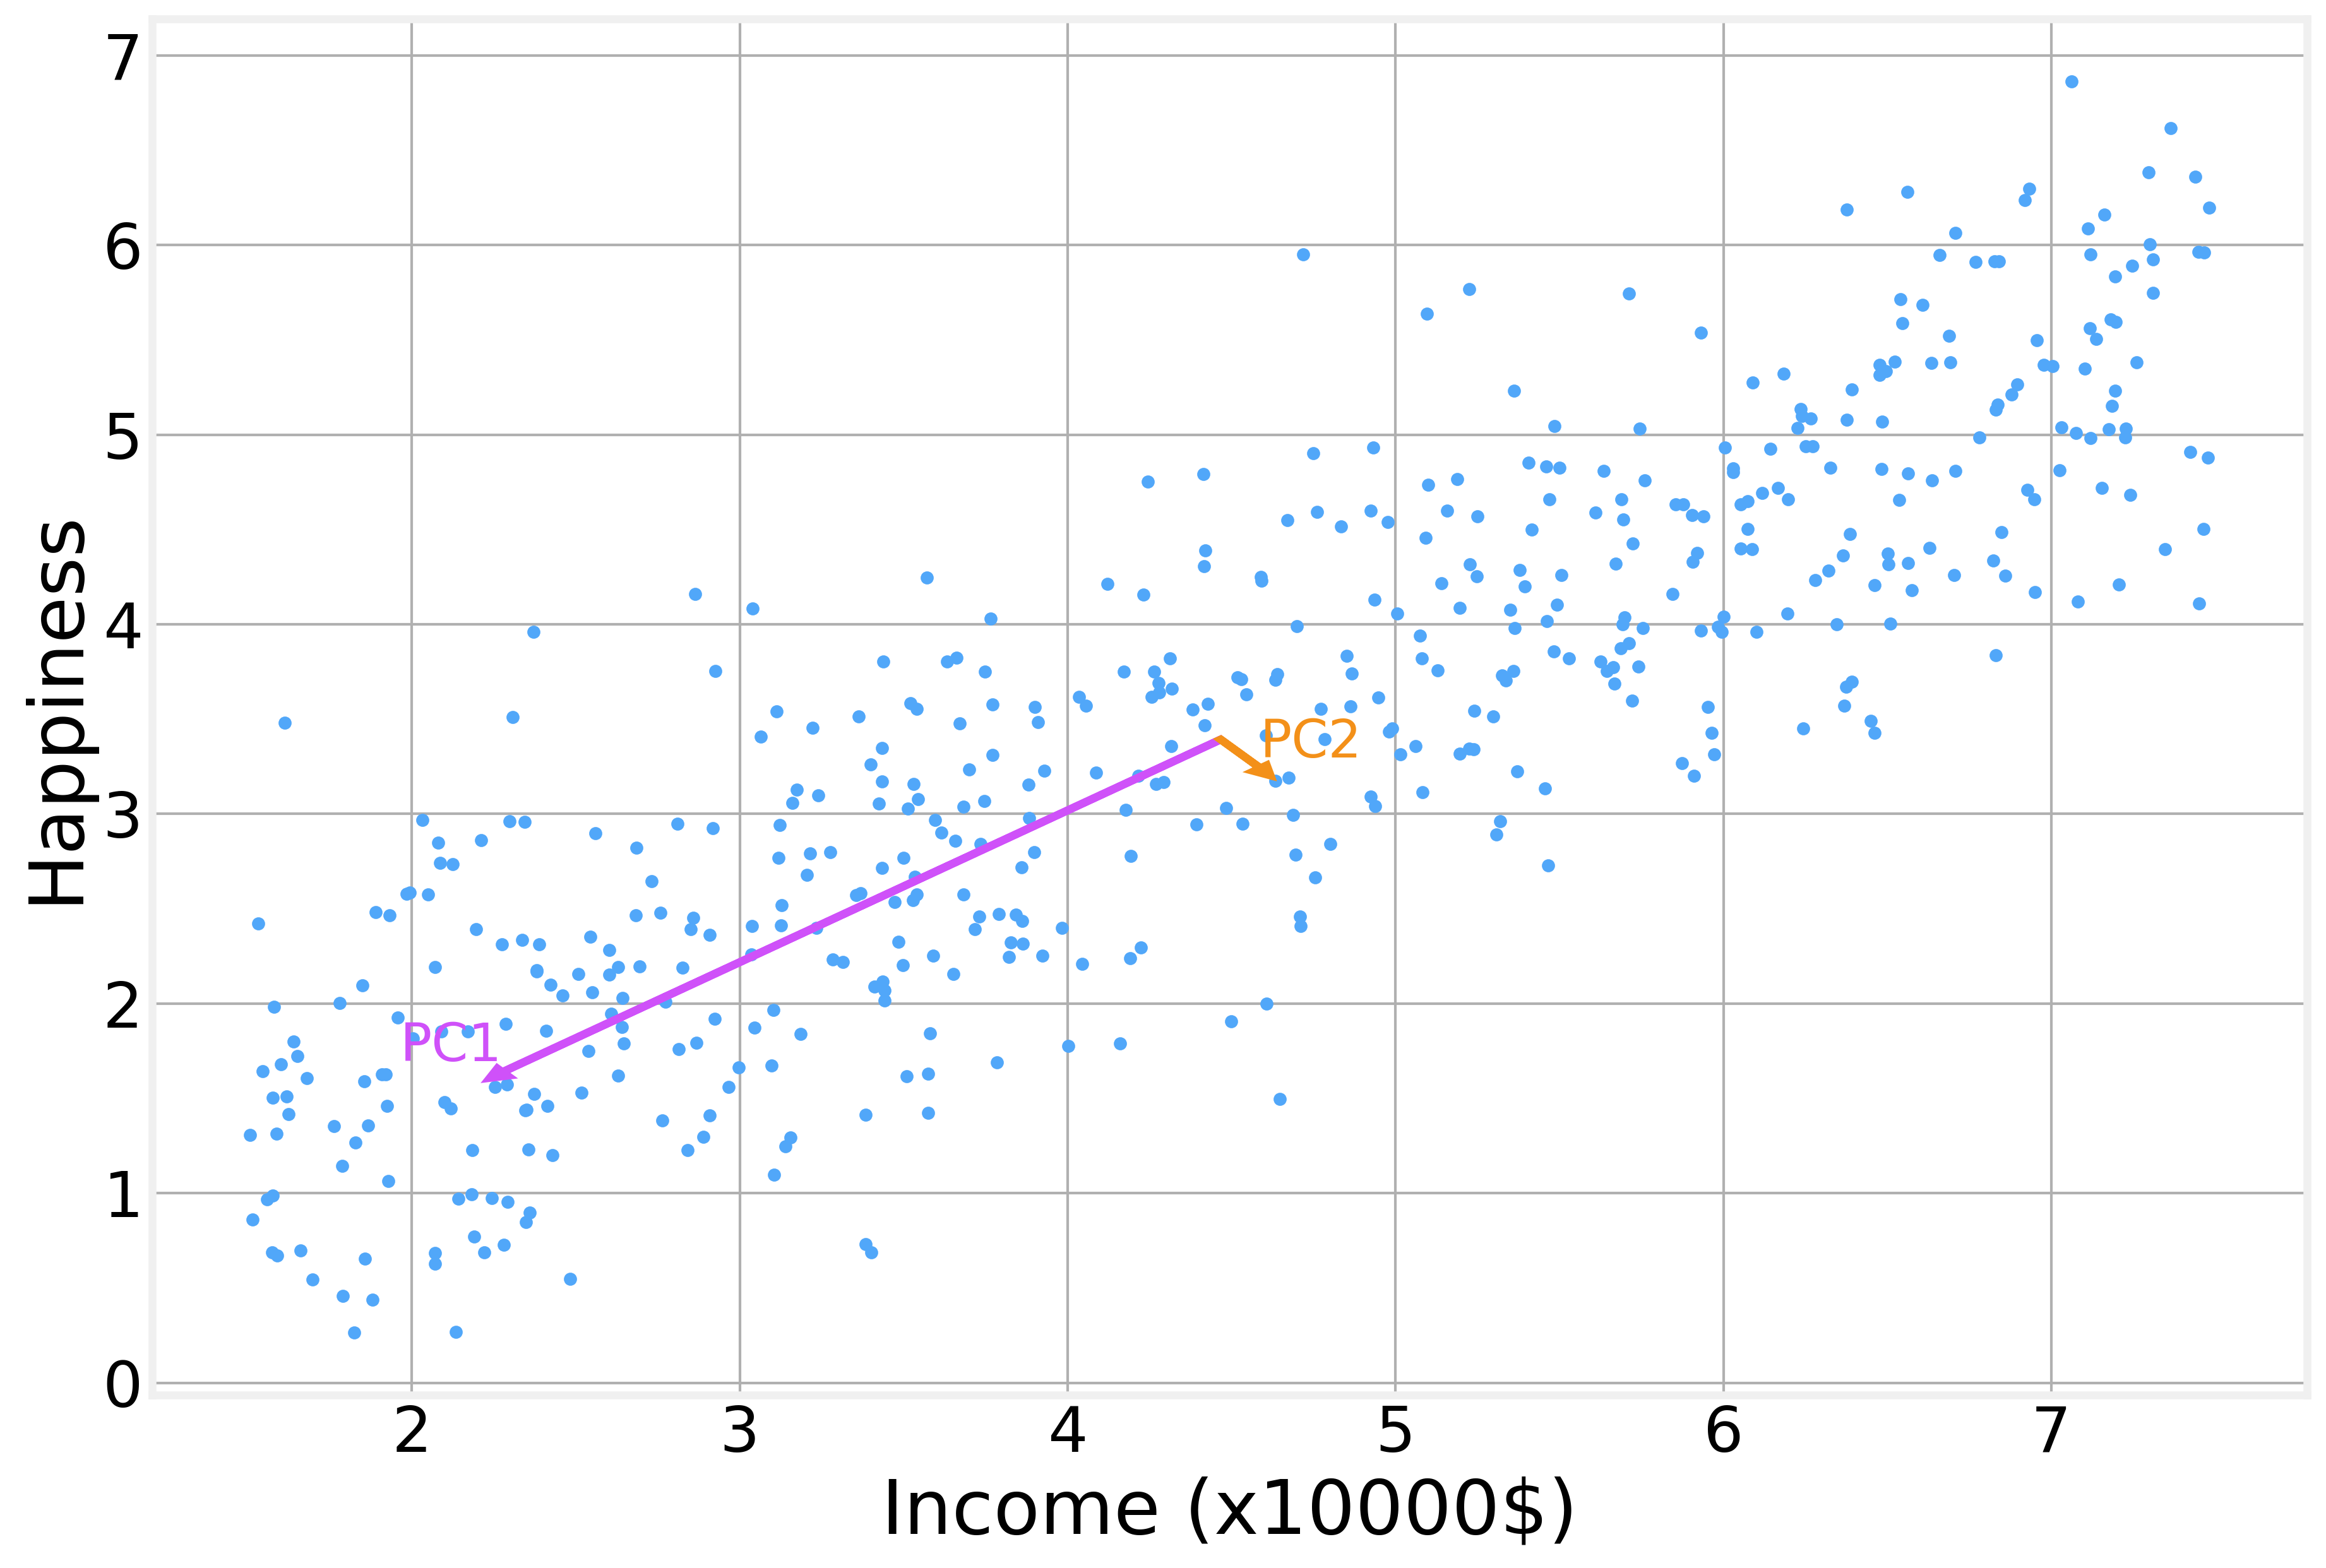

In [9]:
ax = data.plot(x='income', y='happiness', kind='scatter')
ax.set_xlabel('Income (x10000$)')
ax.set_ylabel('Happiness')

meanX, meanY = data.mean(axis=0)

ax.arrow(meanX, meanY, 
         top_eigenvectors[0, 0]*explained_variance[0]*3,
         top_eigenvectors[1, 0]*explained_variance[0]*3,
         head_width=0.05, head_length=0.05, fc='k',  lw=3, color=colors[1])
ax.arrow(meanX, meanY, 
         top_eigenvectors[0, 1]*explained_variance[1]*3,
         top_eigenvectors[1, 1]*explained_variance[1]*3,
         head_width=0.05, head_length=0.05, fc='k',  lw=3, color=colors[3])
ax.text(meanX + top_eigenvectors[0, 0]*explained_variance[0]*3,
        meanY + top_eigenvectors[1, 0]*explained_variance[0]*3,
        'PC1', fontsize=20, c=colors[1], verticalalignment='bottom', horizontalalignment='right')
ax.text(meanX + top_eigenvectors[0, 1]*explained_variance[1]*3,
        meanY + top_eigenvectors[1, 1]*explained_variance[1]*3,
        'PC2', fontsize=20, c=colors[3], verticalalignment='bottom', horizontalalignment='left')

# K-Means

In [10]:
def kmeans(data, k, max_iters=100, tolerance=1e-4, verbose=False):
    """
    K-means clustering using PyTorch.
    
    Args:
        data (torch.Tensor): Input data tensor of shape [n_samples, n_features]
        k (int): Number of clusters
        max_iters (int): Maximum number of iterations
        tolerance (float): Convergence threshold for centroid changes
        
    Returns:
        centroids (torch.Tensor): Final cluster centroids
        labels (torch.Tensor): Cluster assignments for each data point
    """
    # Get dimensions
    n_samples = data.shape[0]
    
    # Initialize centroids by randomly selecting k data points
    indices = torch.randperm(n_samples)[:k]
    centroids = data[indices[:k]]
    
    # Previous centroids for convergence check
    prev_centroids = torch.zeros_like(centroids)
    
    # Iteration counter
    iteration = 0
    
    if verbose:
        timeseries = []

    # Continue until convergence or max iterations
    while iteration < max_iters:
        # Compute distances between each point and each centroid
        # Shape: [n_samples, k]
        distances = torch.cdist(data, centroids, p=2)
        
        # Assign each point to the nearest centroid
        # Shape: [n_samples]
        labels = torch.argmin(distances, dim=1)
        
        # Save previous centroids for convergence check
        prev_centroids = centroids.clone()
        
        if verbose:
            timeseries.append(centroids.clone())

        # Update centroids based on mean of assigned points
        for i in range(k):
            # Get points assigned to this cluster
            cluster_points = data[labels == i]
            
            # If the cluster has points, update the centroid
            if len(cluster_points) > 0:
                centroids[i] = cluster_points.mean(dim=0)
        
        # Check for convergence
        centroid_shift = torch.norm((centroids - prev_centroids)/prev_centroids)
        if centroid_shift < tolerance:
            print(f"Converged after {iteration+1} iterations")
            break
            
        iteration += 1
    
    if iteration == max_iters:
        print(f"K-means did not converge in {max_iters} iterations")
    
    if not verbose:
        return centroids, labels
    else:
        timeseries = torch.stack(timeseries)
        timeseries = timeseries.flatten().reshape(-1, k*data.shape[1])
        return centroids, labels, timeseries

Generate synthetic data

In [11]:
n_samples = 300
manual_centroids = [[2.0, 2.0],
                    [-2.0, 2.0],
                    [0.0, -2.0]]

data = None

for centroid in manual_centroids:
    cluster = torch.randn(n_samples, 2) + torch.tensor(centroid)

    if data is None:
        data = cluster
    else:
        data = torch.cat([data, cluster], dim=0)

data = data[torch.randperm(data.shape[0])].clone()

Visualize the data we generated

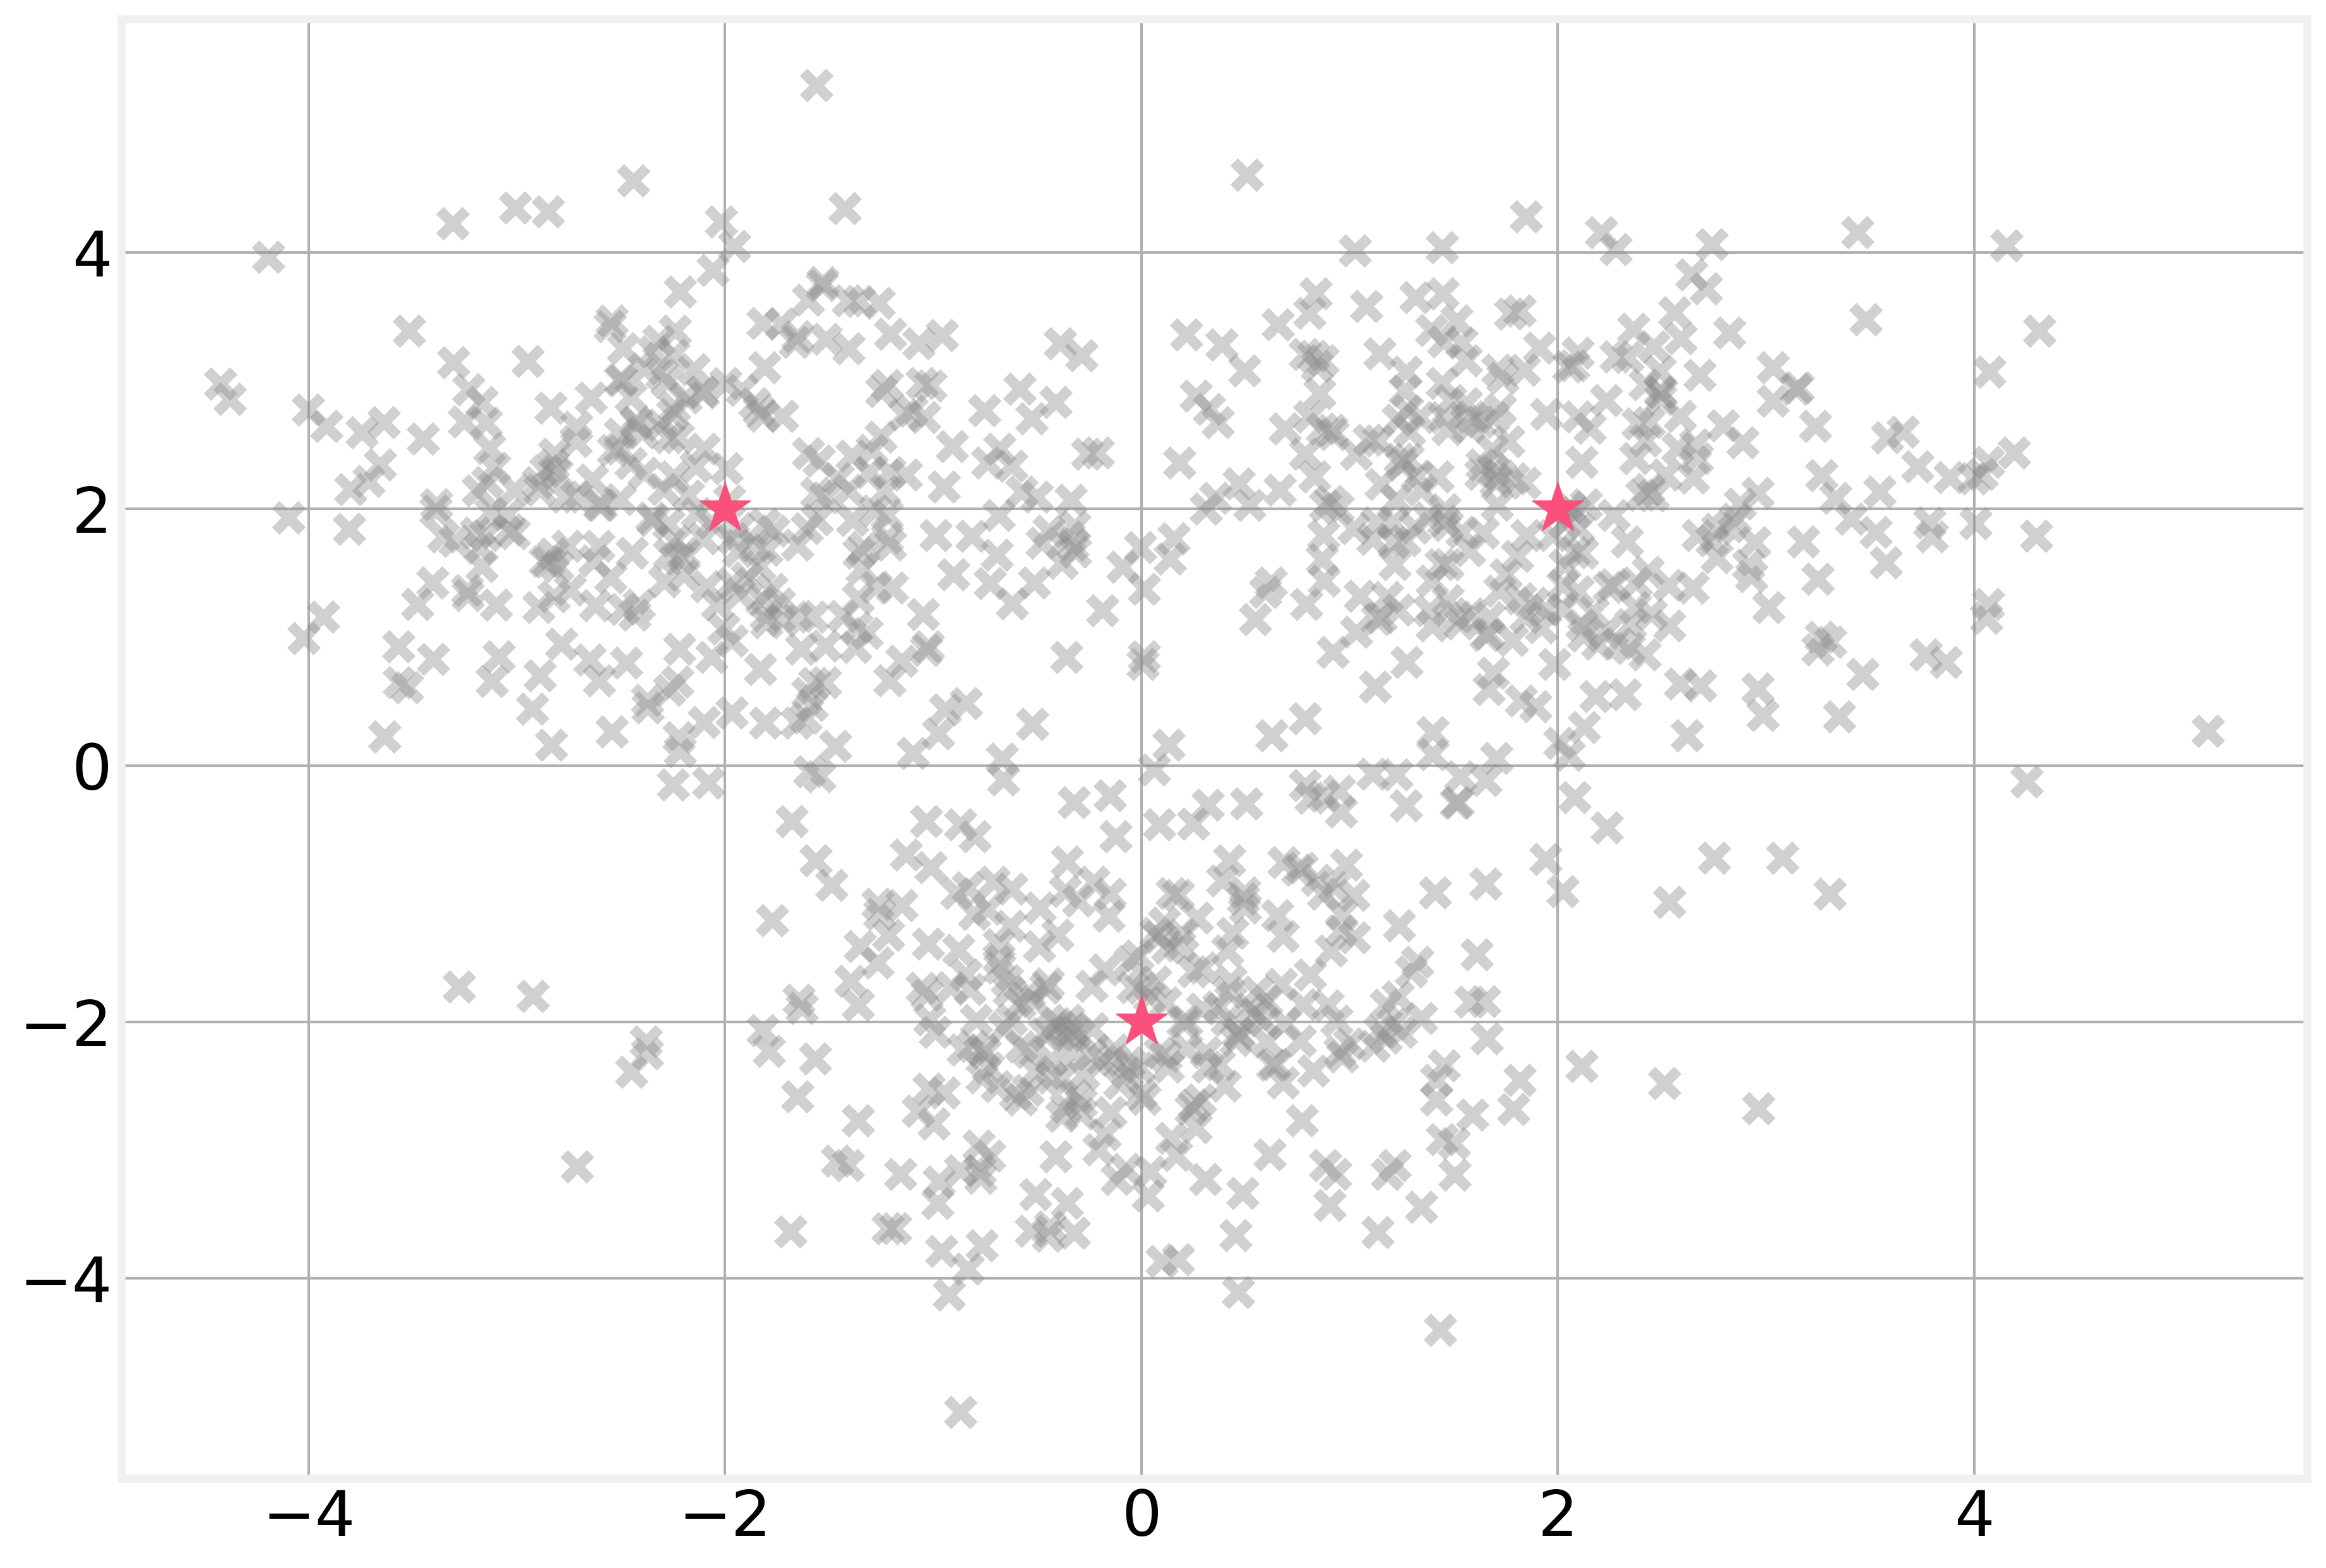

In [12]:
fig, ax = plt.subplots(1)
ax.scatter(data[:, 0].cpu(), data[:, 1].cpu(), s=100, c=colors[7], marker='x', alpha=0.4)

manual_coordinates = np.array(manual_centroids)

ax.scatter(
        manual_coordinates[:, 0], 
        manual_coordinates[:, 1], 
        c=colors[5], 
        marker='*', 
        s=400
    )

Run K-Means

In [13]:
centroids, labels, timeseries = kmeans(data, k=3, verbose=True)

Converged after 11 iterations


In [14]:
print("Final centroids:")
print(centroids)

Final centroids:
tensor([[ 1.9651,  1.9982],
        [-0.0179, -1.9769],
        [-2.0589,  1.9914]])


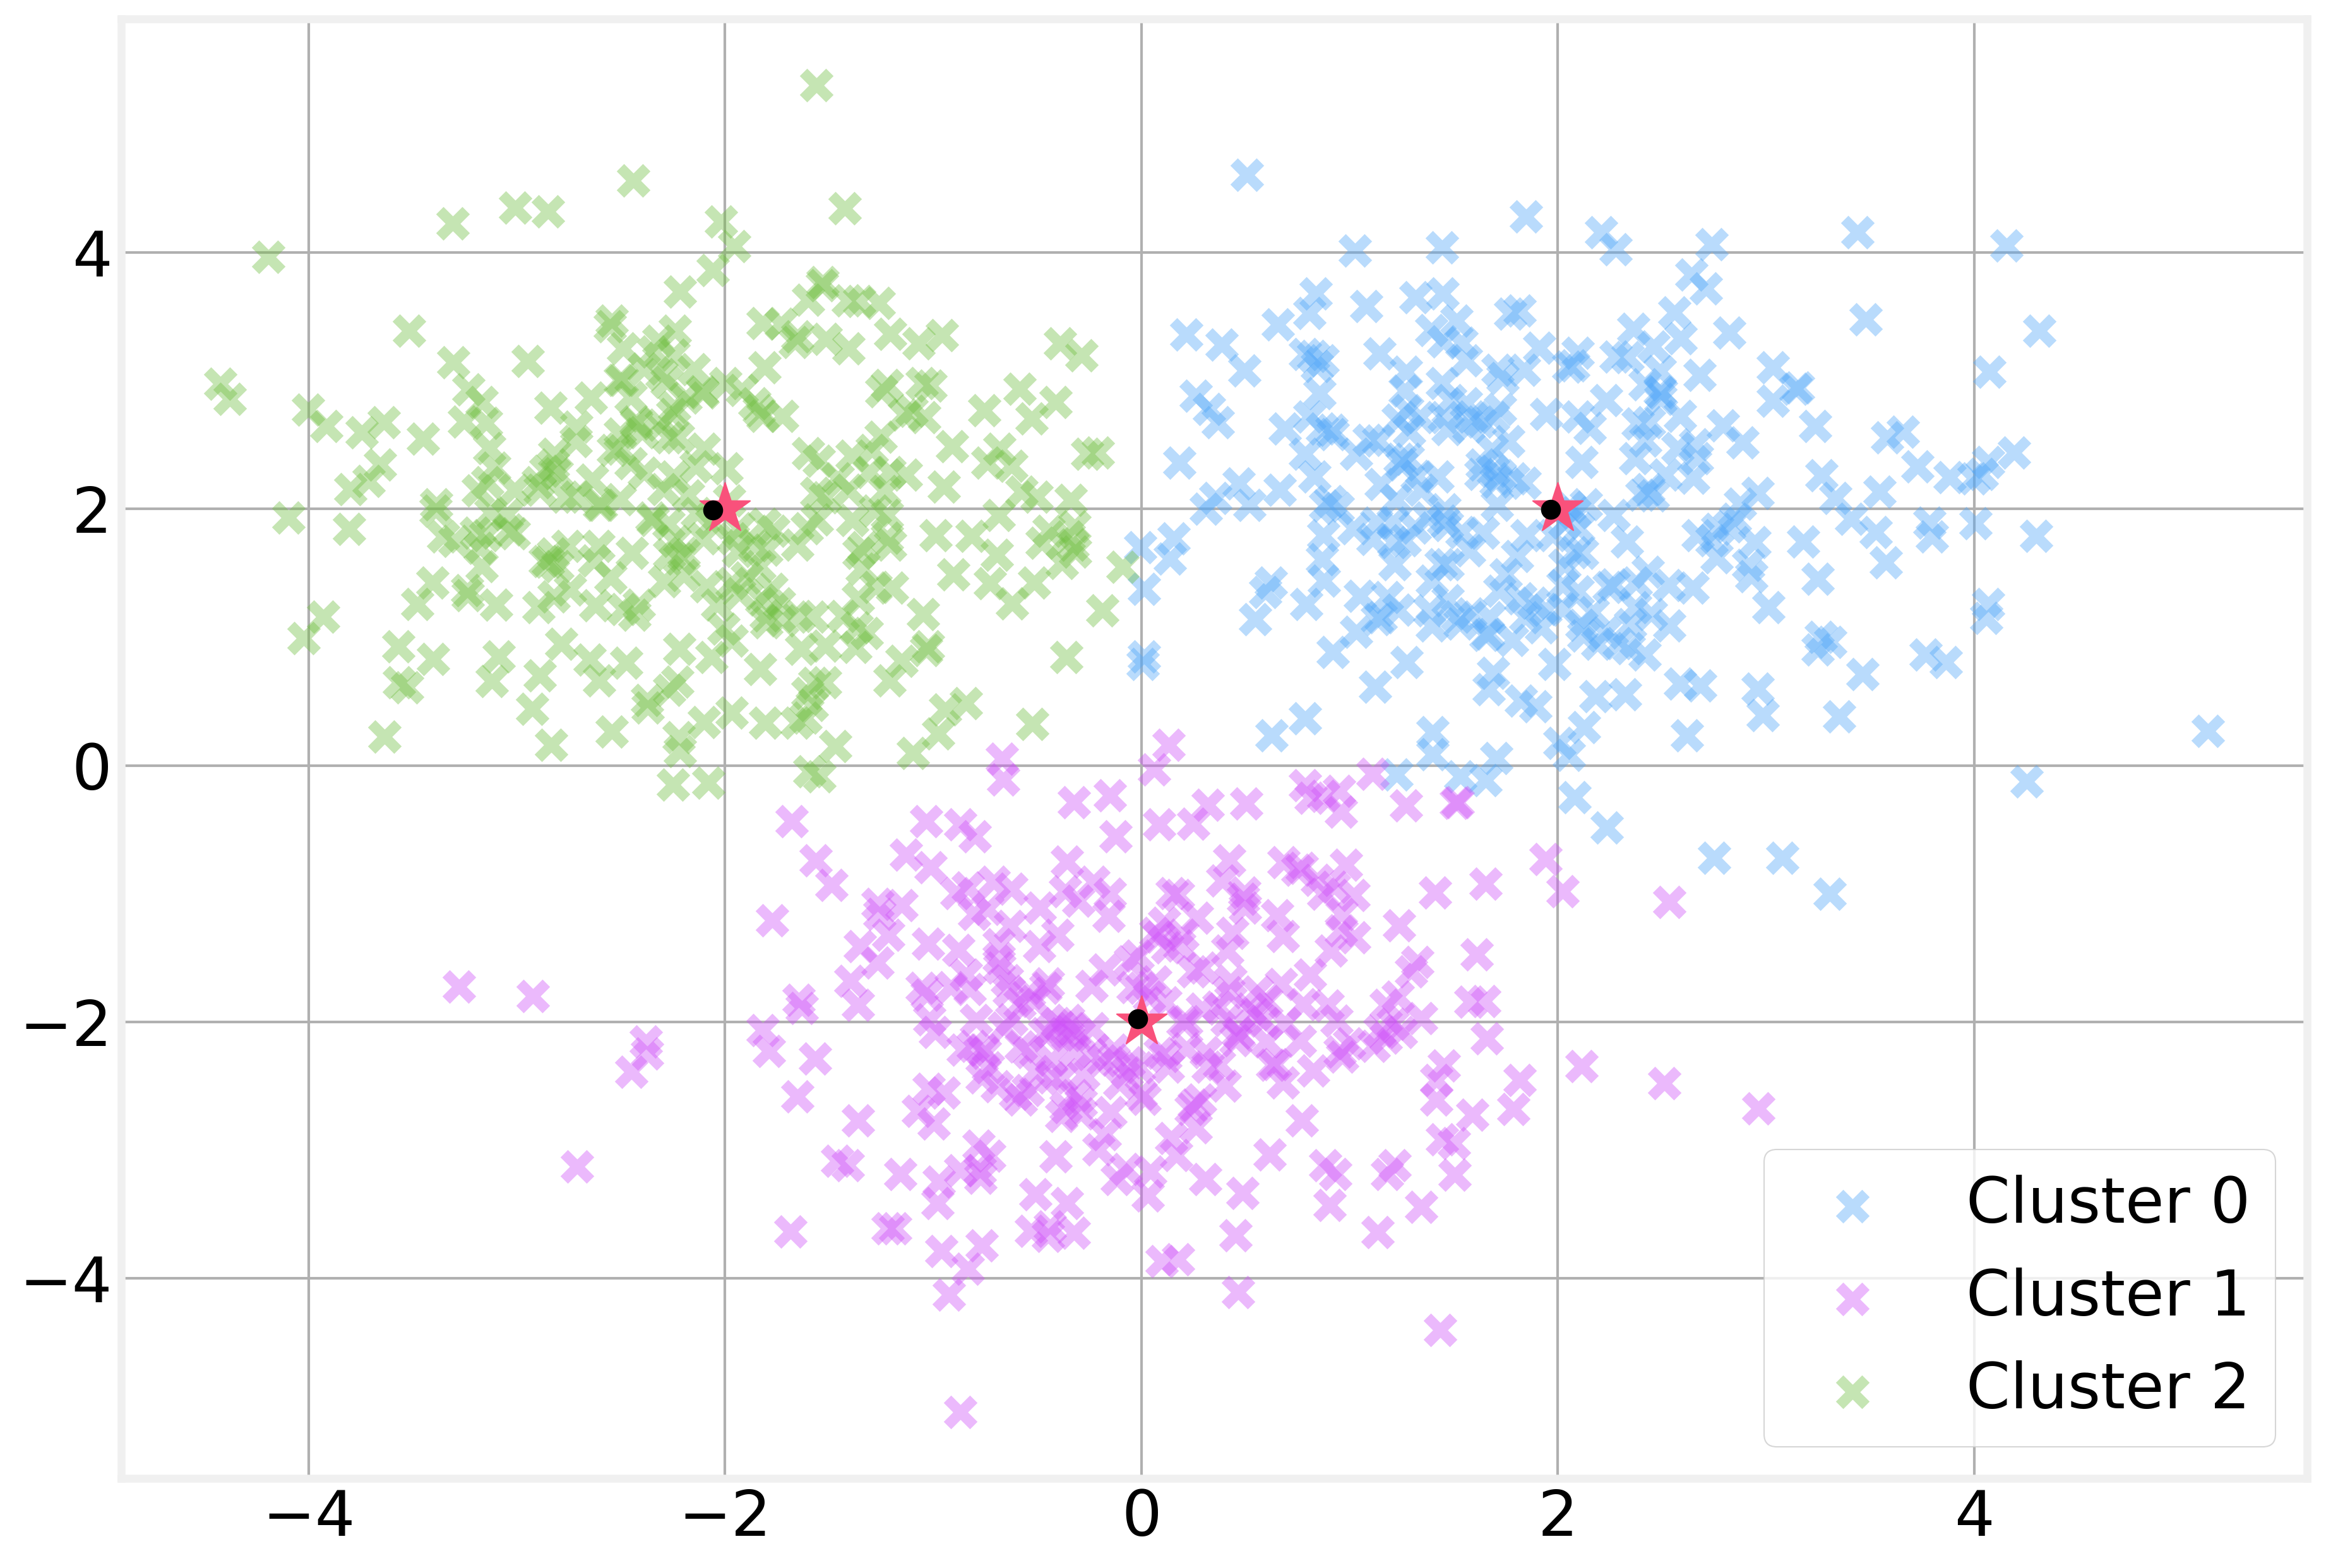

In [15]:
fig, ax = plt.subplots(1)
for i, centroid in enumerate(centroids):
    ax.scatter(data[labels == i, 0].cpu(), 
               data[labels == i, 1].cpu(), 
               s=100, c=colors[i], 
               marker='x', 
               alpha=0.4,
               label=f'Cluster {i}')

manual_coordinates = np.array(manual_centroids)

ax.scatter(
        manual_coordinates[:, 0], 
        manual_coordinates[:, 1], 
        c=colors[5], 
        marker='*', 
        s=400
    )

ax.scatter(
        centroids[:, 0].cpu(), 
        centroids[:, 1].cpu(), 
        c='black', 
        marker='.', 
        s=200
    )

ax.legend()

In [16]:
t = pd.DataFrame(timeseries.numpy(), columns=['x' + str(i//2) if i%2==0 else 'y' + str(i//2) for i in range(2*len(centroids))])

Text(0.5, 0, '')

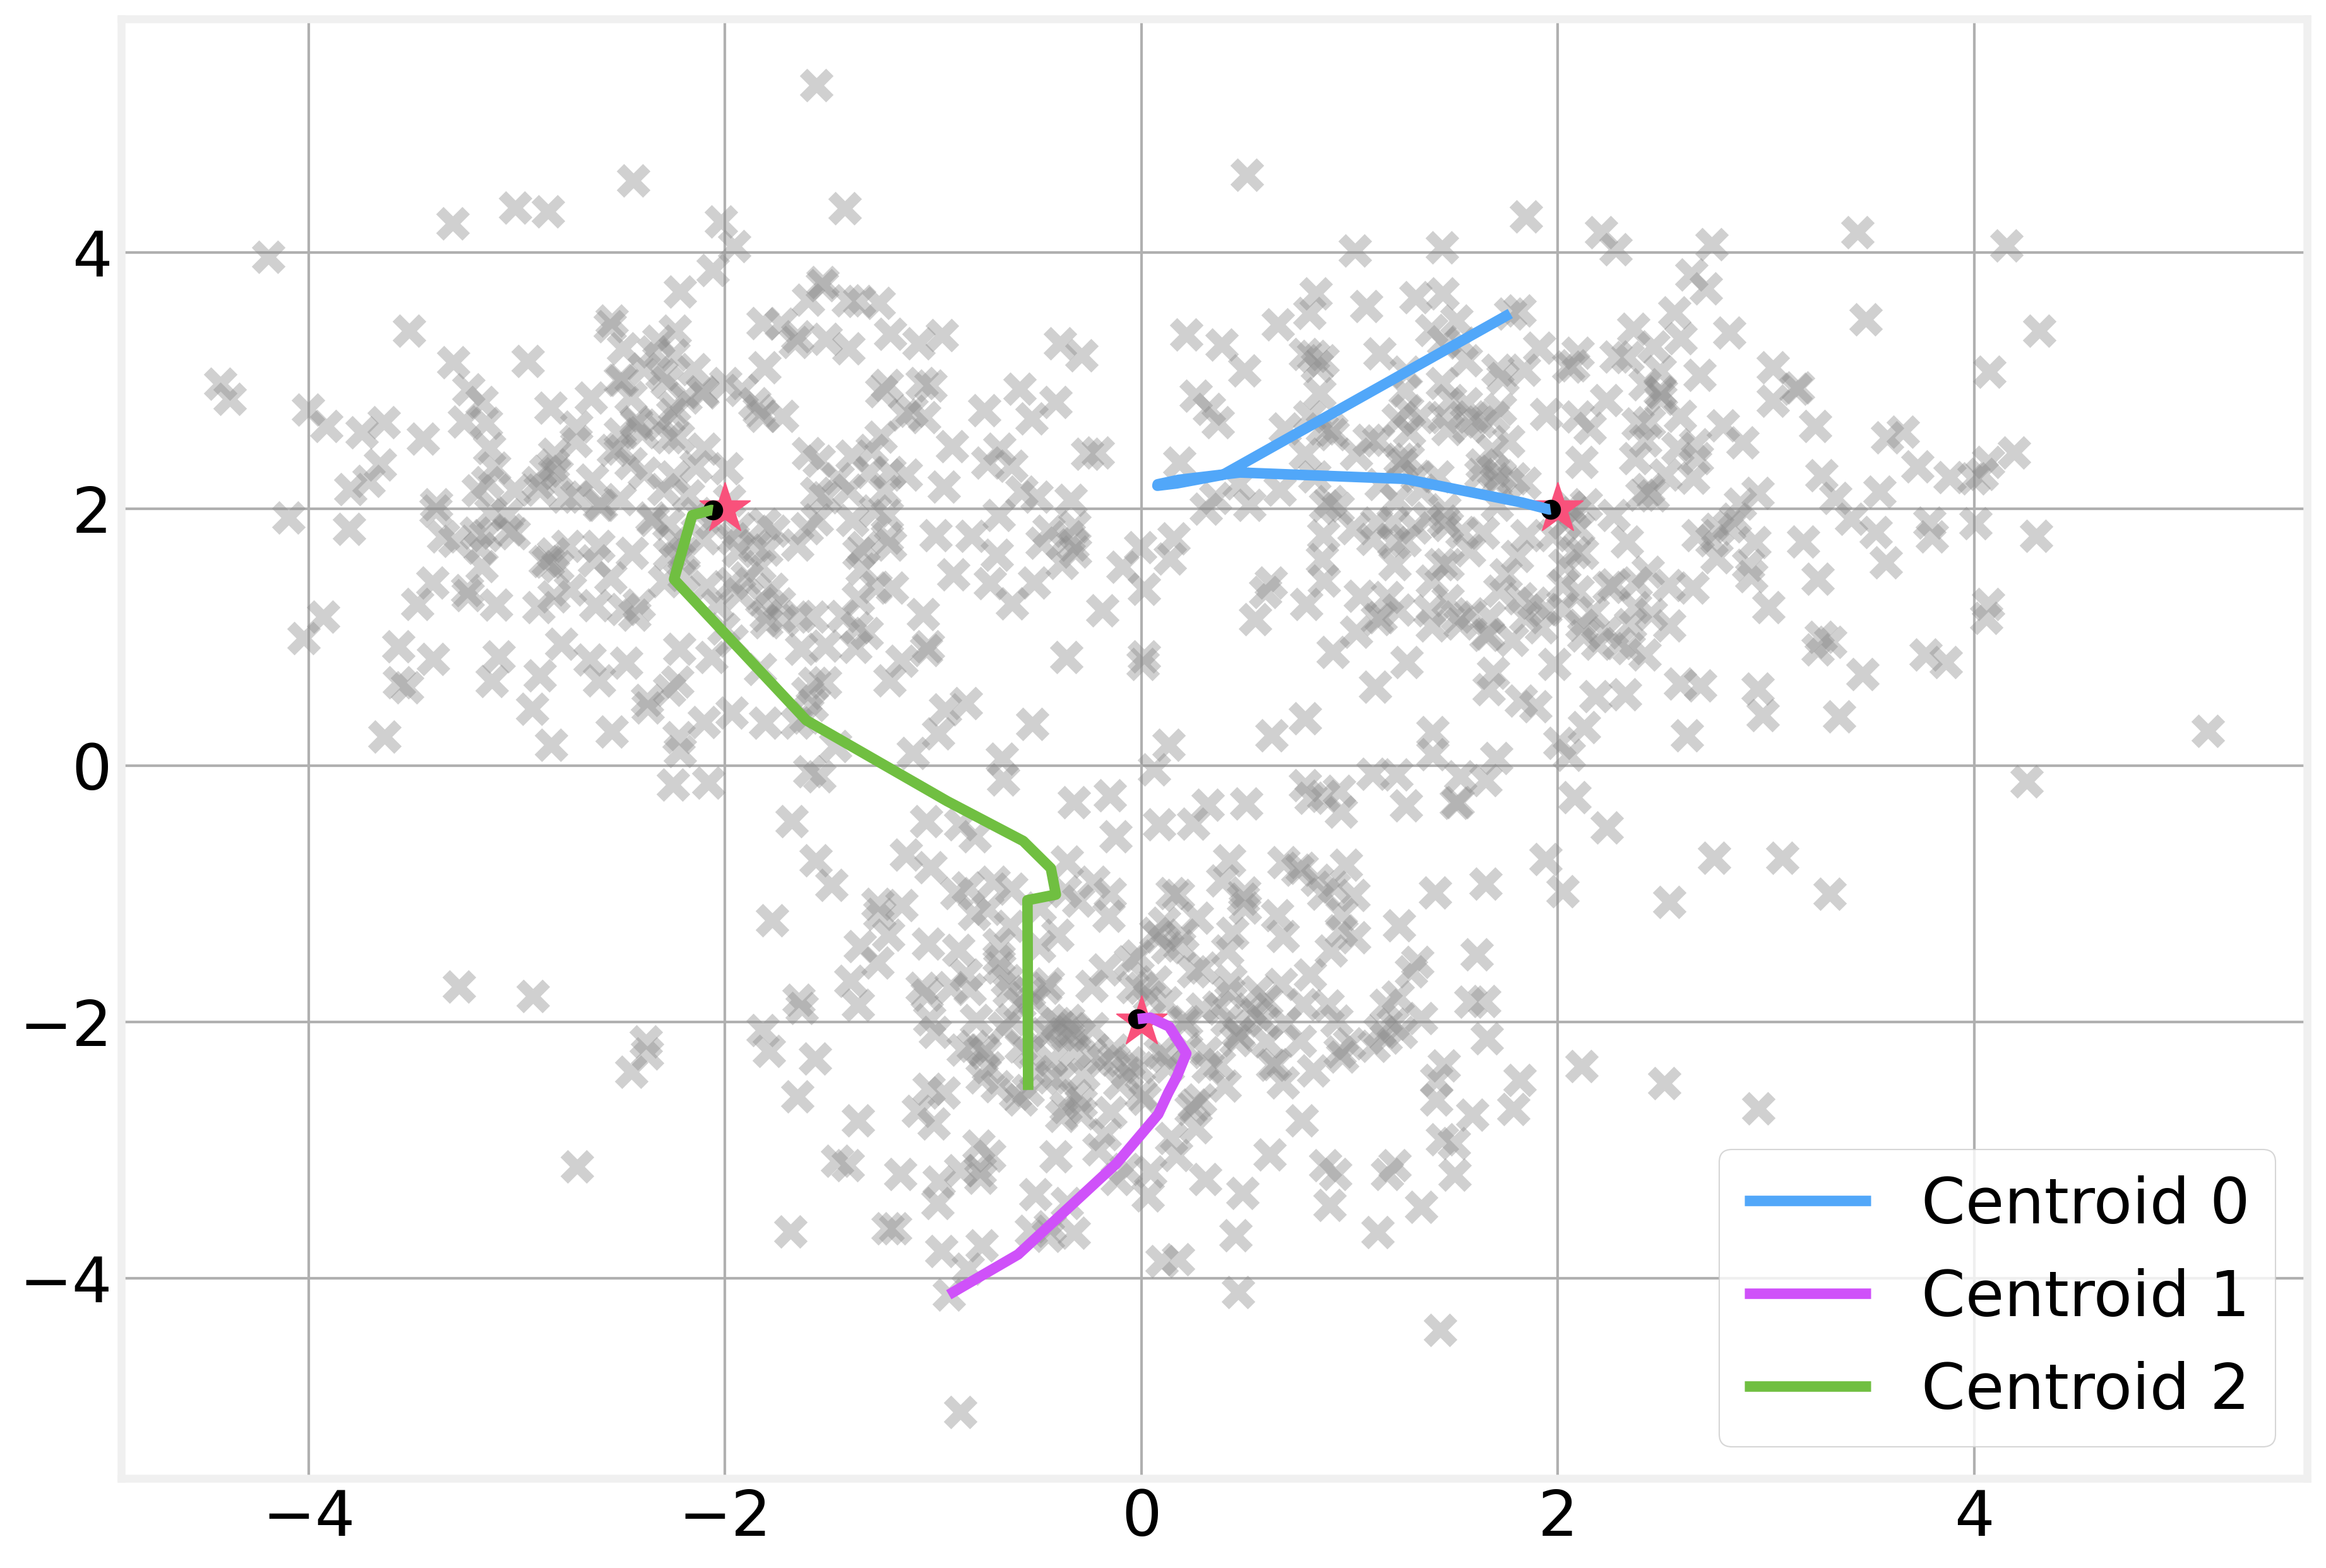

In [17]:
fig, ax = plt.subplots(1)
ax.scatter(data[:, 0].cpu(), data[:, 1].cpu(), s=100, c=colors[7], marker='x', alpha=0.4)
ax.set_xlabel(None)

manual_coordinates = np.array(manual_centroids)

ax.scatter(
        manual_coordinates[:, 0], 
        manual_coordinates[:, 1], 
        c=colors[5], 
        marker='*', 
        s=400
    )

ax.scatter(
        centroids[:, 0].cpu(), 
        centroids[:, 1].cpu(), 
        c='black', 
        marker='.', 
        s=200
    )

for i in range(len(centroids)):
    t.plot(x='x%u' % i, y='y%u' % i, kind='line', ax=ax, c=colors[i], label='Centroid %u' % i)

ax.set_xlabel('')

Now let's consider a different dataset:

In [18]:
moons, y = datasets.make_moons(n_samples=300, noise=0.08, shuffle=False)

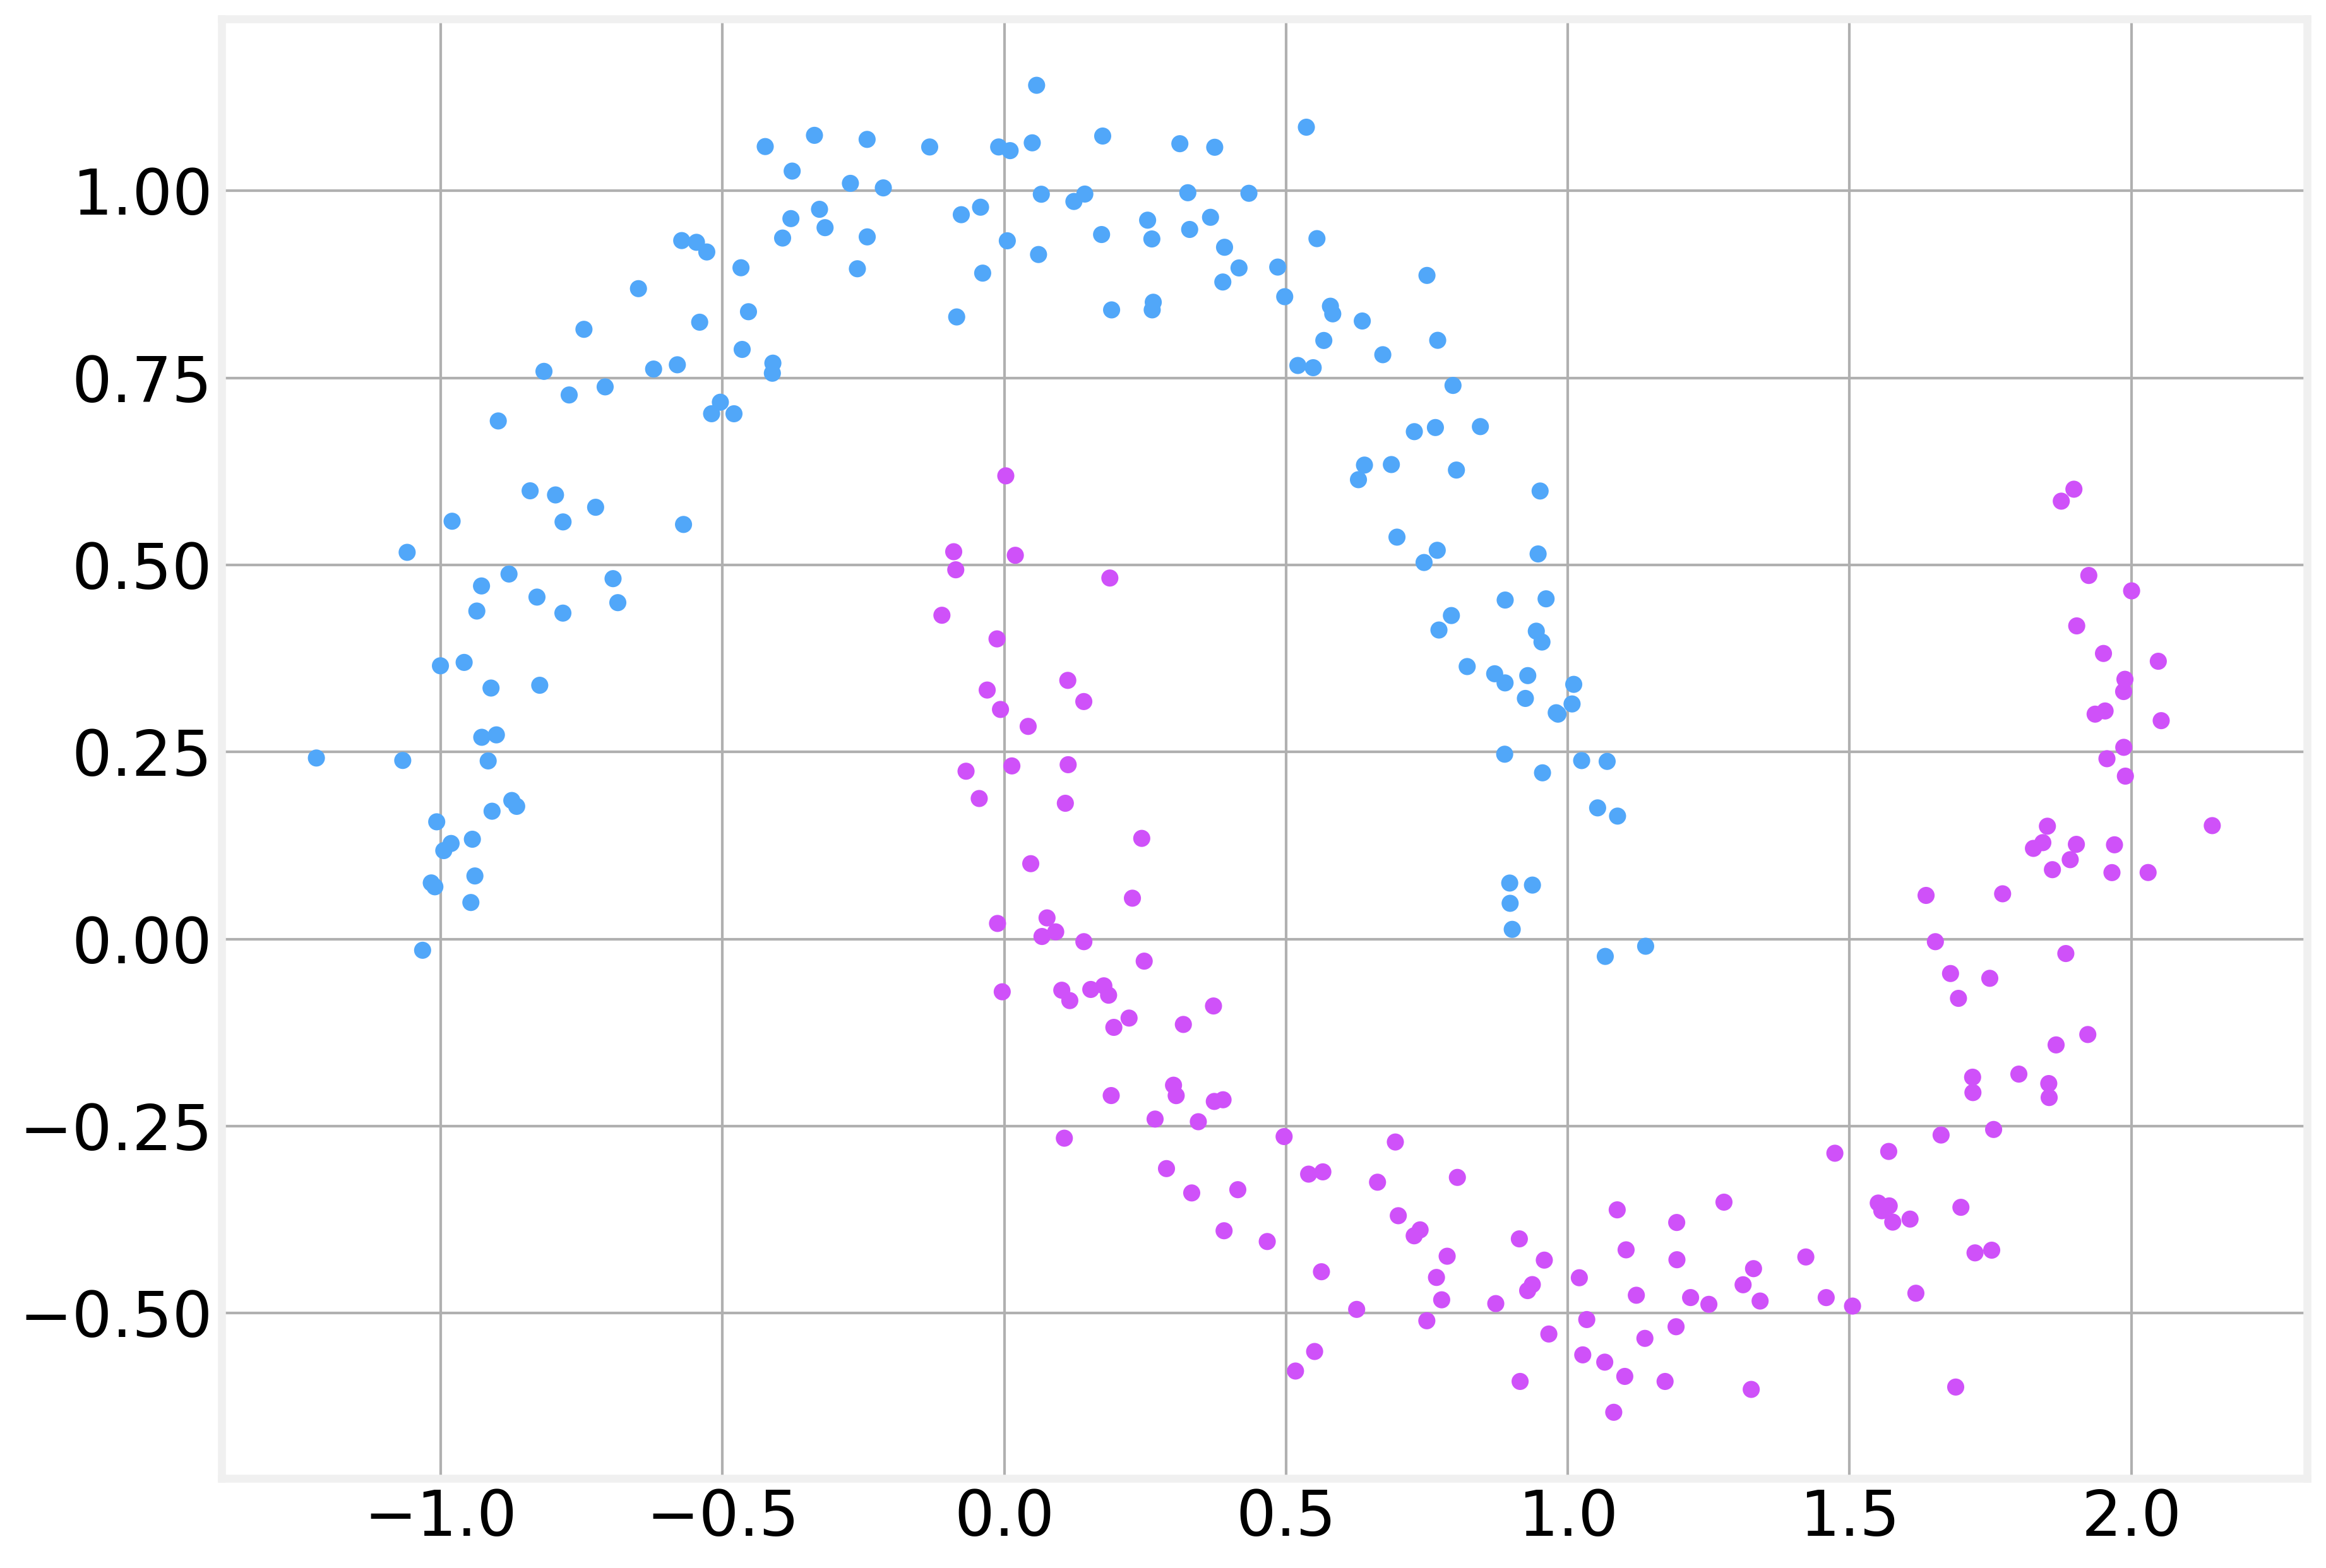

In [19]:
plt.scatter(moons.T[0], moons.T[1], color=np.array(colors)[y])

Due to the clusters shape, kmeans fails at correctly identifying the two clusters

In [20]:
centroids, labels = kmeans(torch.Tensor(moons), k=2)

Converged after 6 iterations


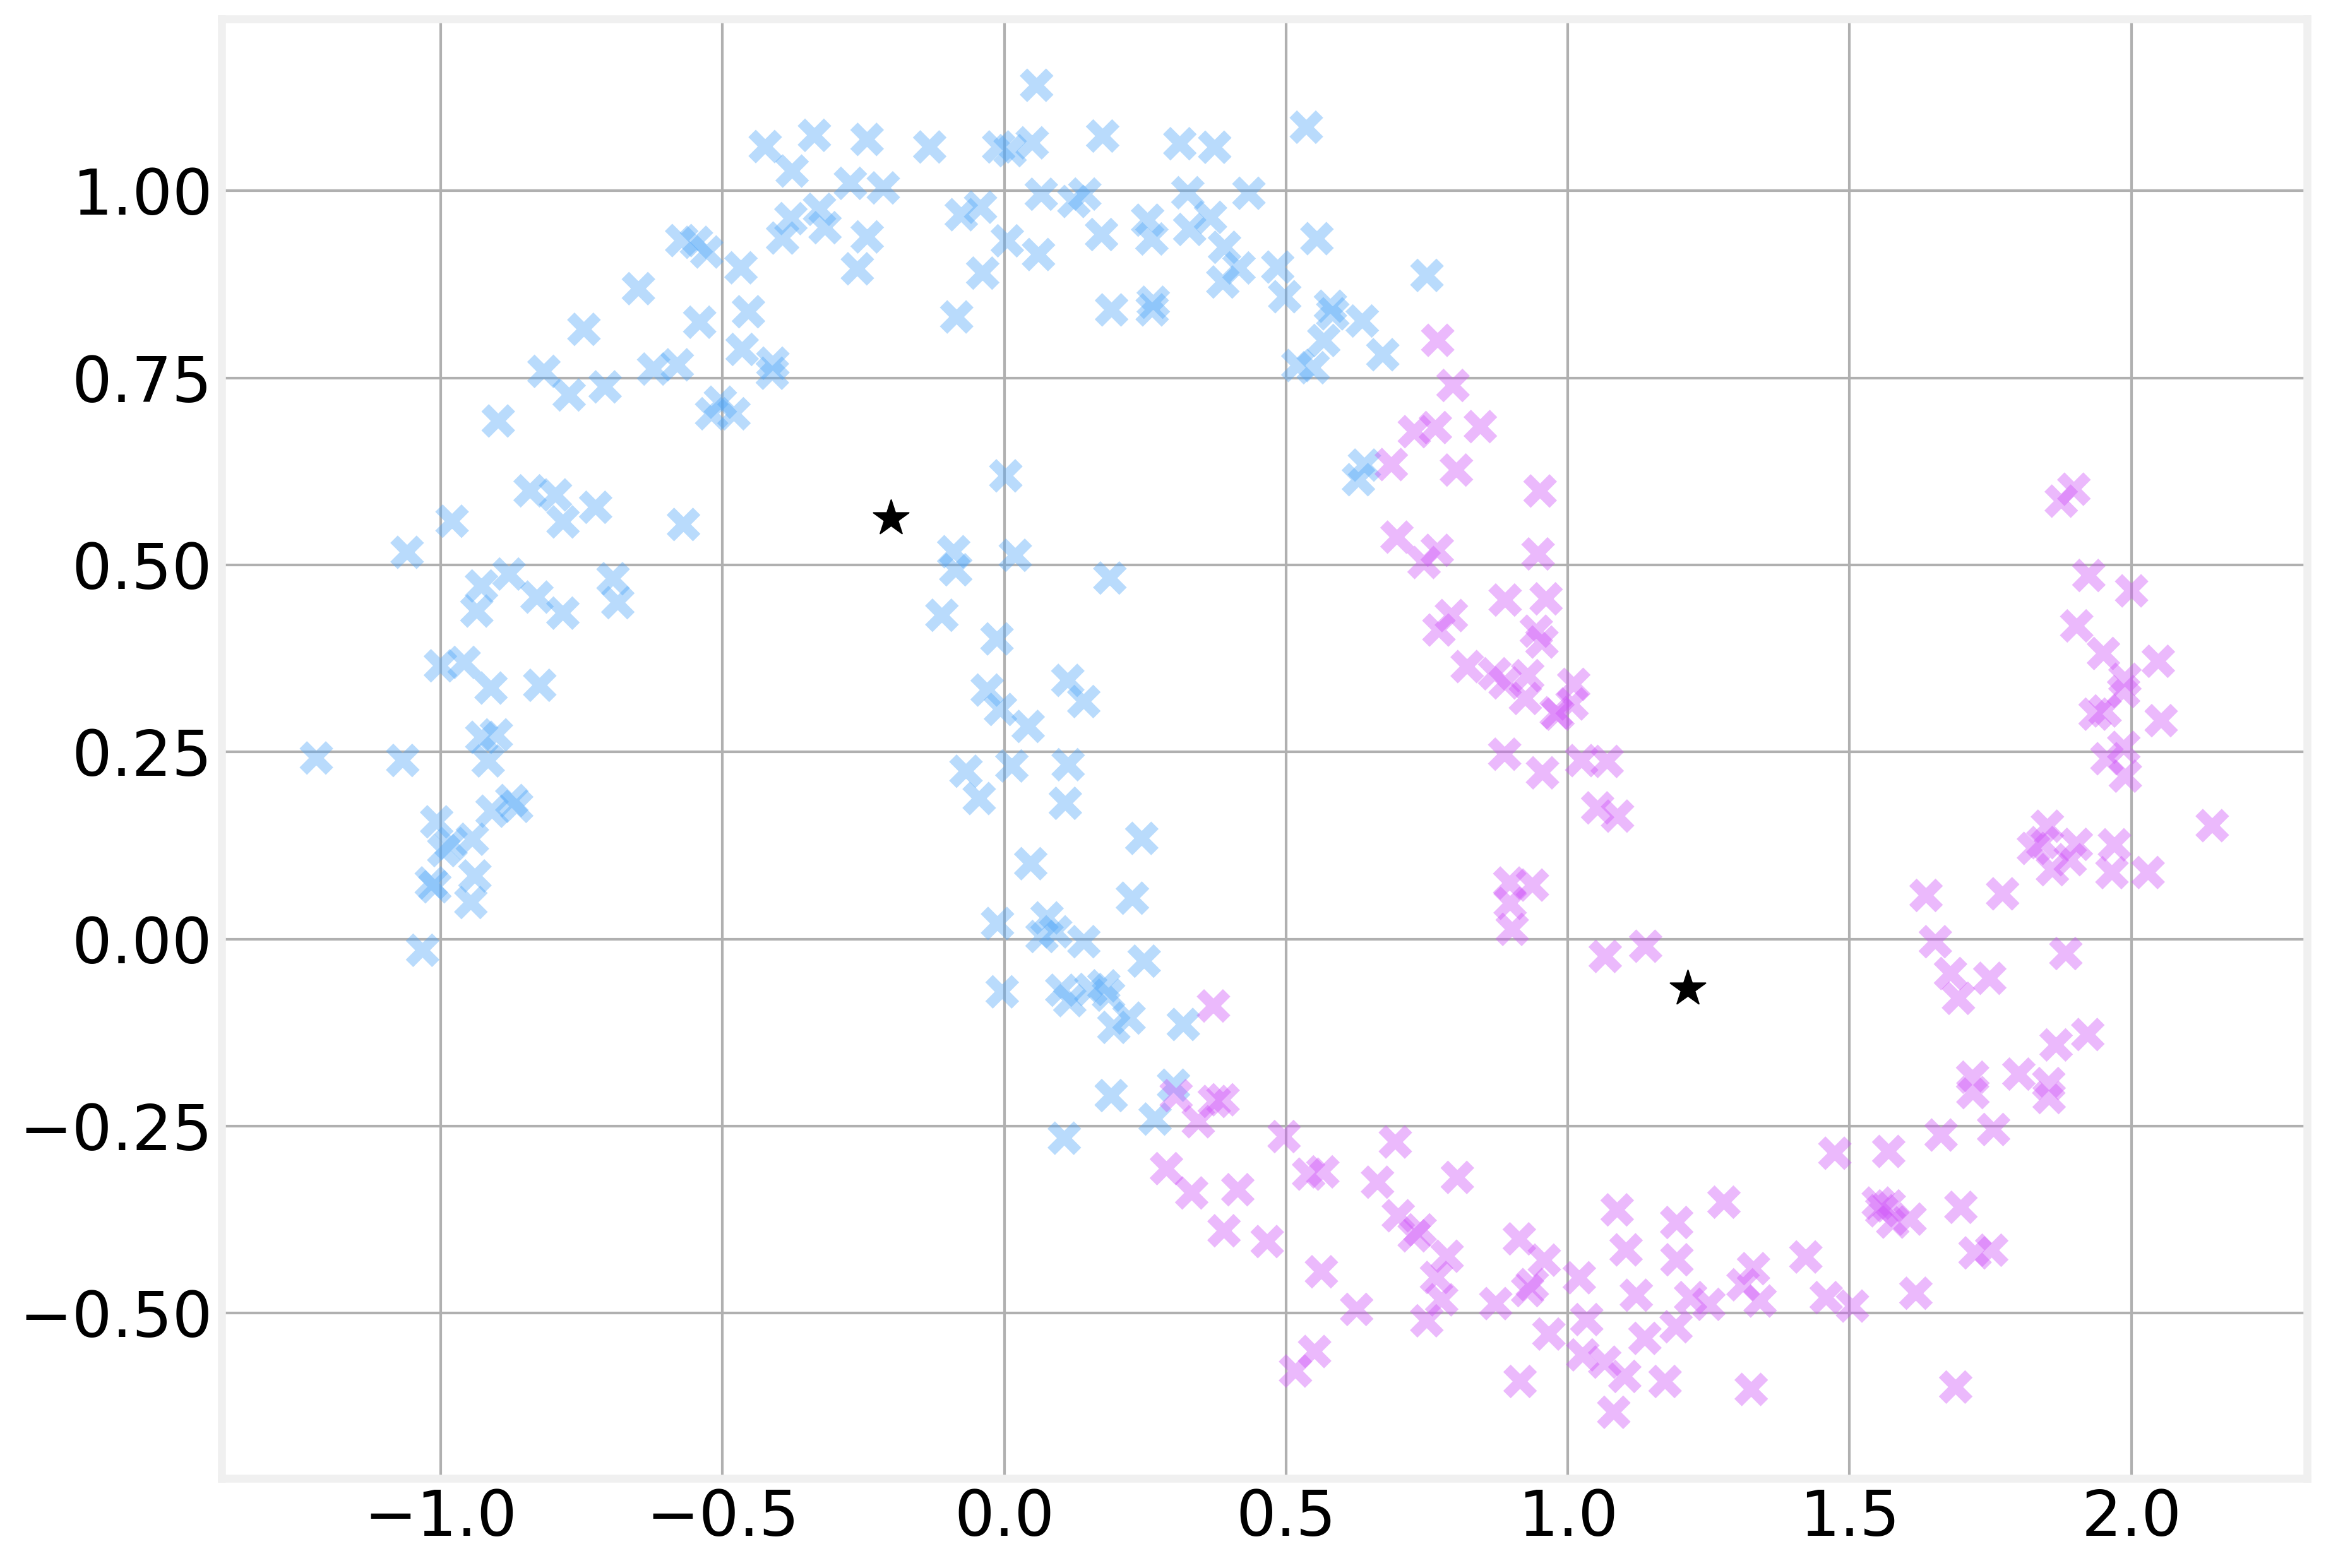

In [21]:
fig, ax = plt.subplots(1)
ax.scatter(moons.T[0], moons.T[1], s=100, c=np.array(colors)[labels], marker='x', alpha=0.4)
ax.scatter(
        centroids[:, 0].cpu(), 
        centroids[:, 1].cpu(), 
        c='black', 
        marker='*', 
        s=200
    )

# DBScan

Now we implement the DBSCAN algorithm

In [22]:
def dbscan_torch(data, eps, min_pts):
    """
    A simple DBSCAN implementation using PyTorch.

    Args:
        data (torch.Tensor): A tensor of shape (N, D) representing N data points in D dimensions.
        eps (float): The radius within which to search for neighbors.
        min_samples (int): The minimum number of points required to form a dense region.

    Returns:
        torch.Tensor: A tensor of shape (N,) containing cluster labels.
                       -1 indicates noise.
    """

    N = data.shape[0]
    labels = torch.full((N,), -1, dtype=torch.long)  # Initialize all points as noise
    visited = torch.zeros(N, dtype=torch.bool)
    cluster_id = 0

    def region_query(point_id):
        """Finds all points within eps of point_id."""
        distances = torch.cdist(data[point_id].unsqueeze(0), data)[0]
        neighbors = torch.where(distances <= eps)[0]
        return neighbors

    for i in range(N):
        if visited[i]:
            continue

        visited[i] = True
        neighbors = region_query(i)

        if neighbors.shape[0] < min_pts:
            # Mark as noise (but might be changed later)
            continue

        # Start a new cluster
        labels[i] = cluster_id
        seed_set = neighbors[neighbors != i].tolist()  # Exclude the point itself

        while seed_set:
            j = seed_set.pop(0)

            if visited[j]:
                continue

            visited[j] = True
            labels[j] = cluster_id
            new_neighbors = region_query(j)

            if new_neighbors.shape[0] >= min_pts:
                # Add new neighbors to the seed set
                seed_set_new = new_neighbors[new_neighbors != j].tolist()
                seed_set.extend([x for x in seed_set_new if x not in seed_set]) #avoid duplicates

        cluster_id += 1

    return labels

If we know apply this algorithm to the moons dataset, we see that it performs much better?

In [23]:
labels = dbscan_torch(torch.Tensor(moons), eps=0.2, min_pts=4)

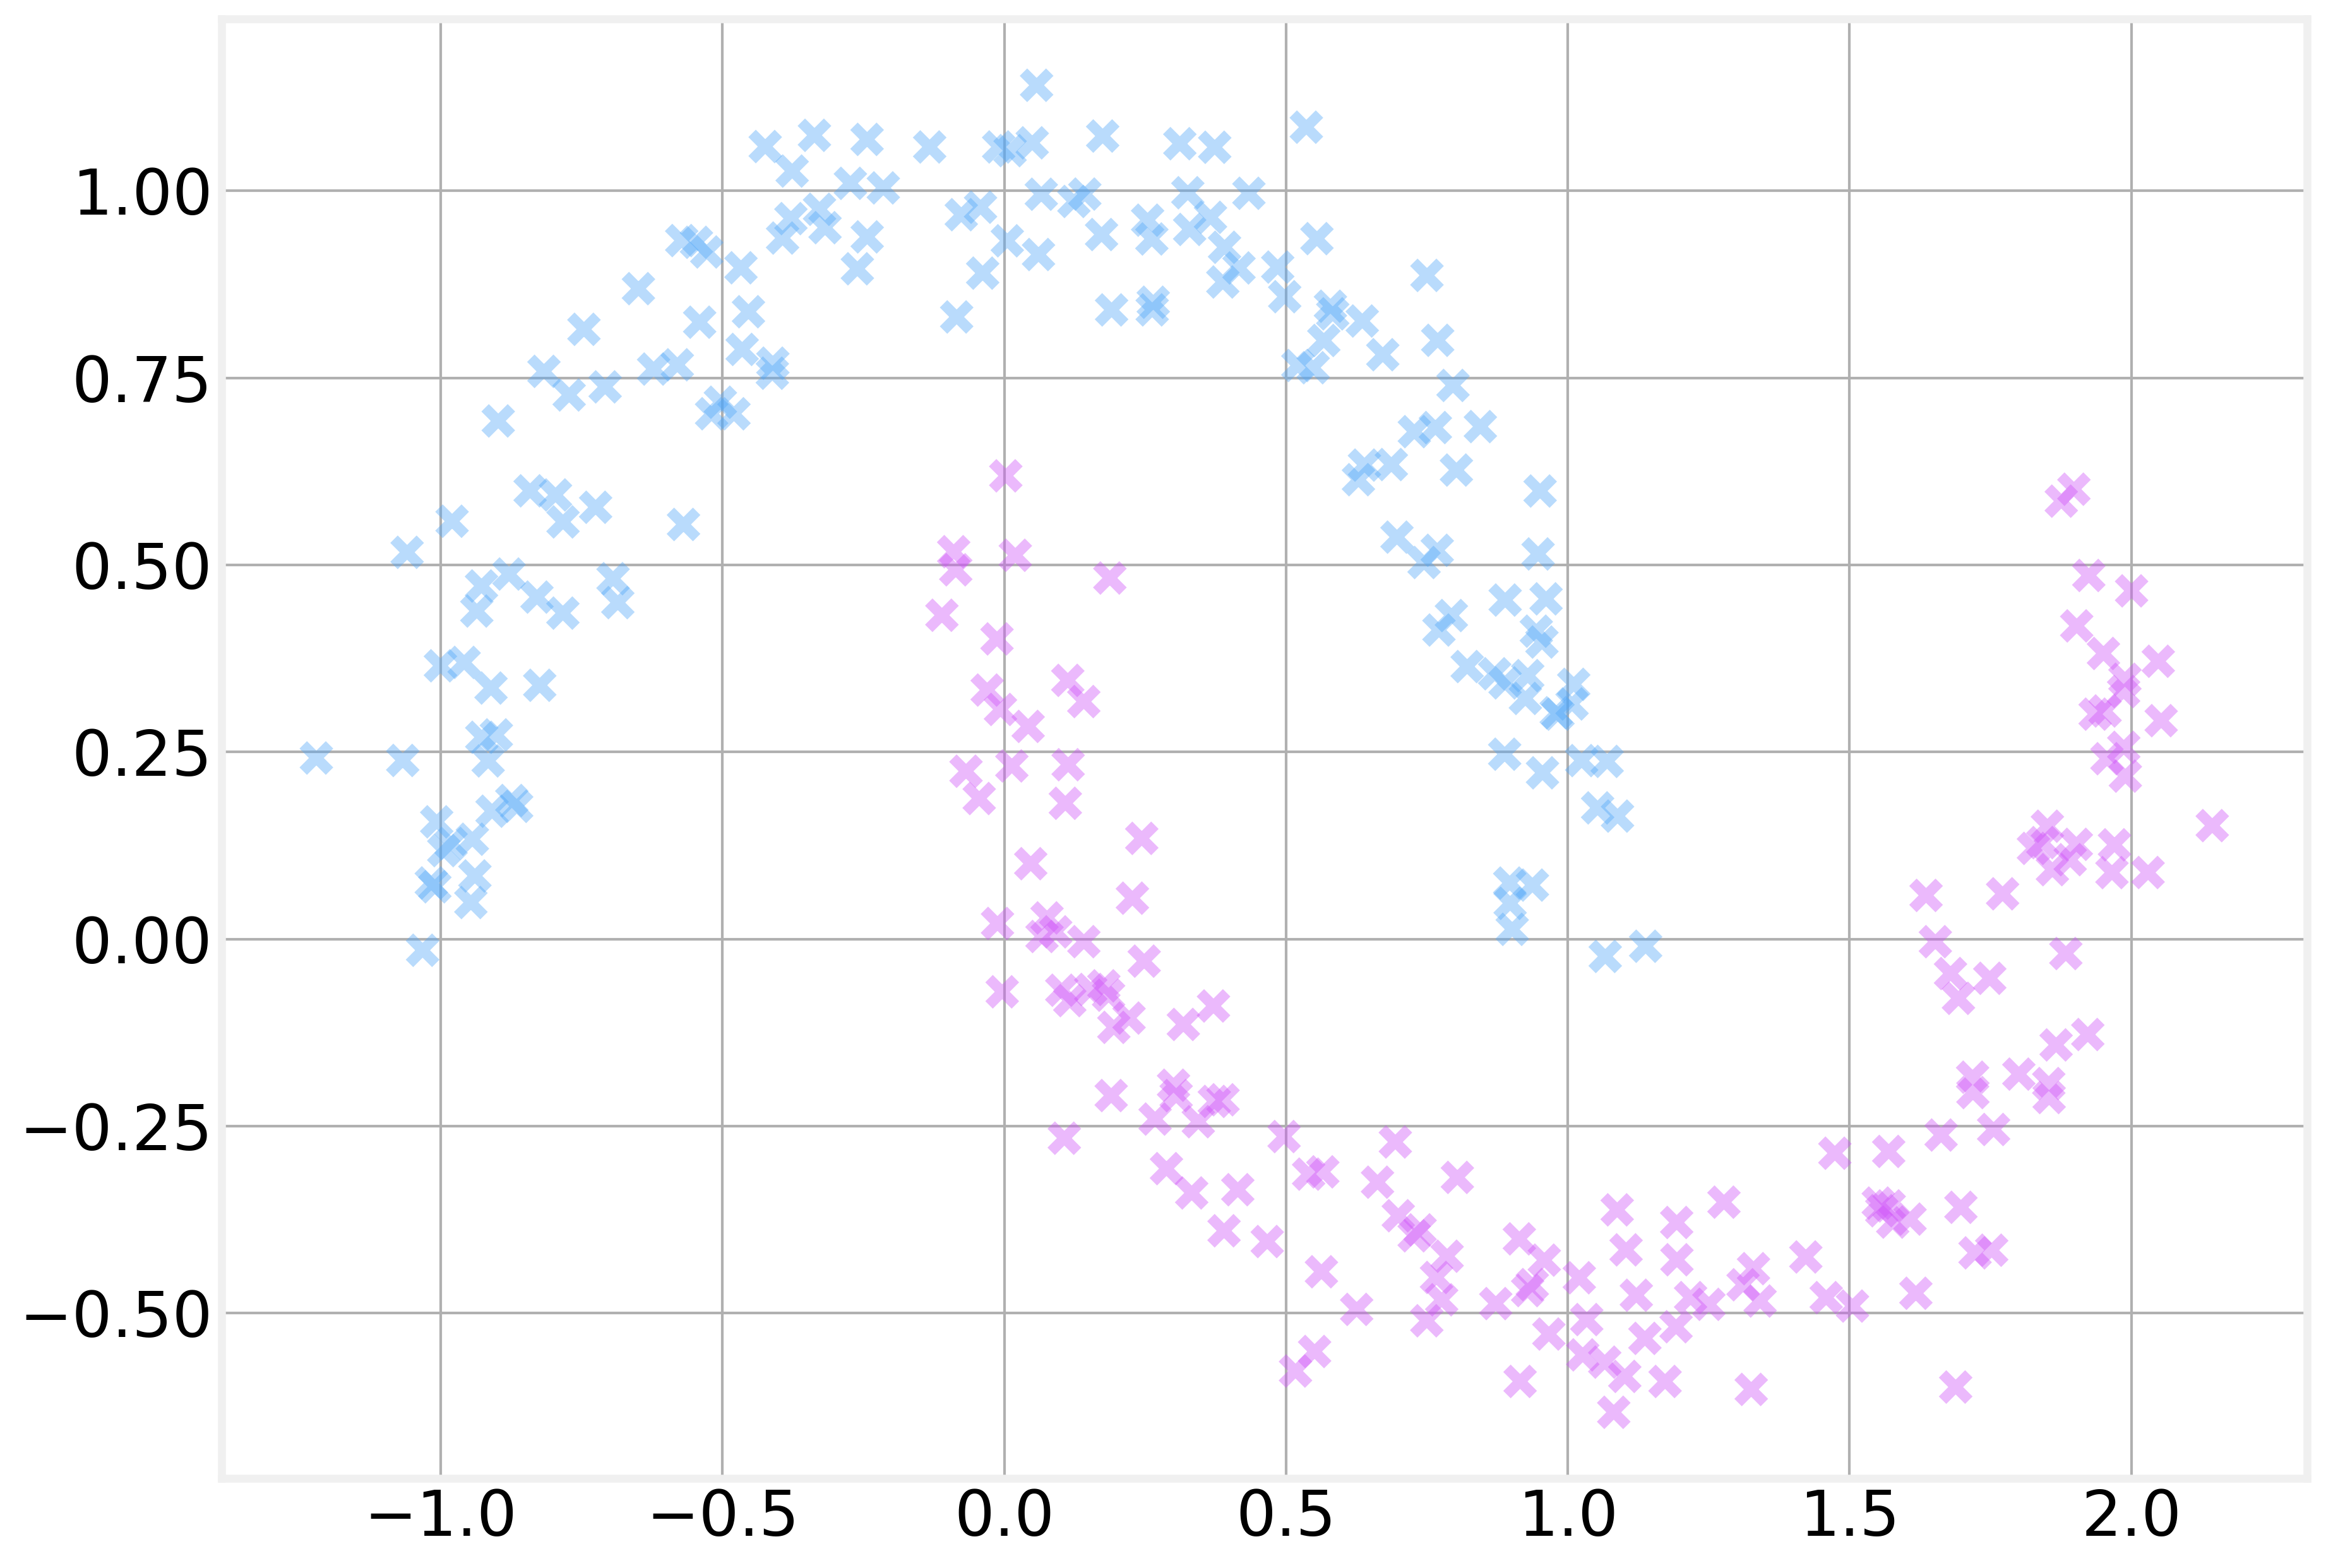

In [24]:
fig, ax = plt.subplots(1)
ax.scatter(moons.T[0], moons.T[1], s=100, c=np.array(colors)[labels], marker='x', alpha=0.4)

Reducing the value of $\epsilon$ can break up clusters, while increasing the value of $\mathrm{MinPts}$ results in larger numbers of outliers

In [25]:
labels = dbscan_torch(torch.Tensor(moons), eps=0.15, min_pts=7)

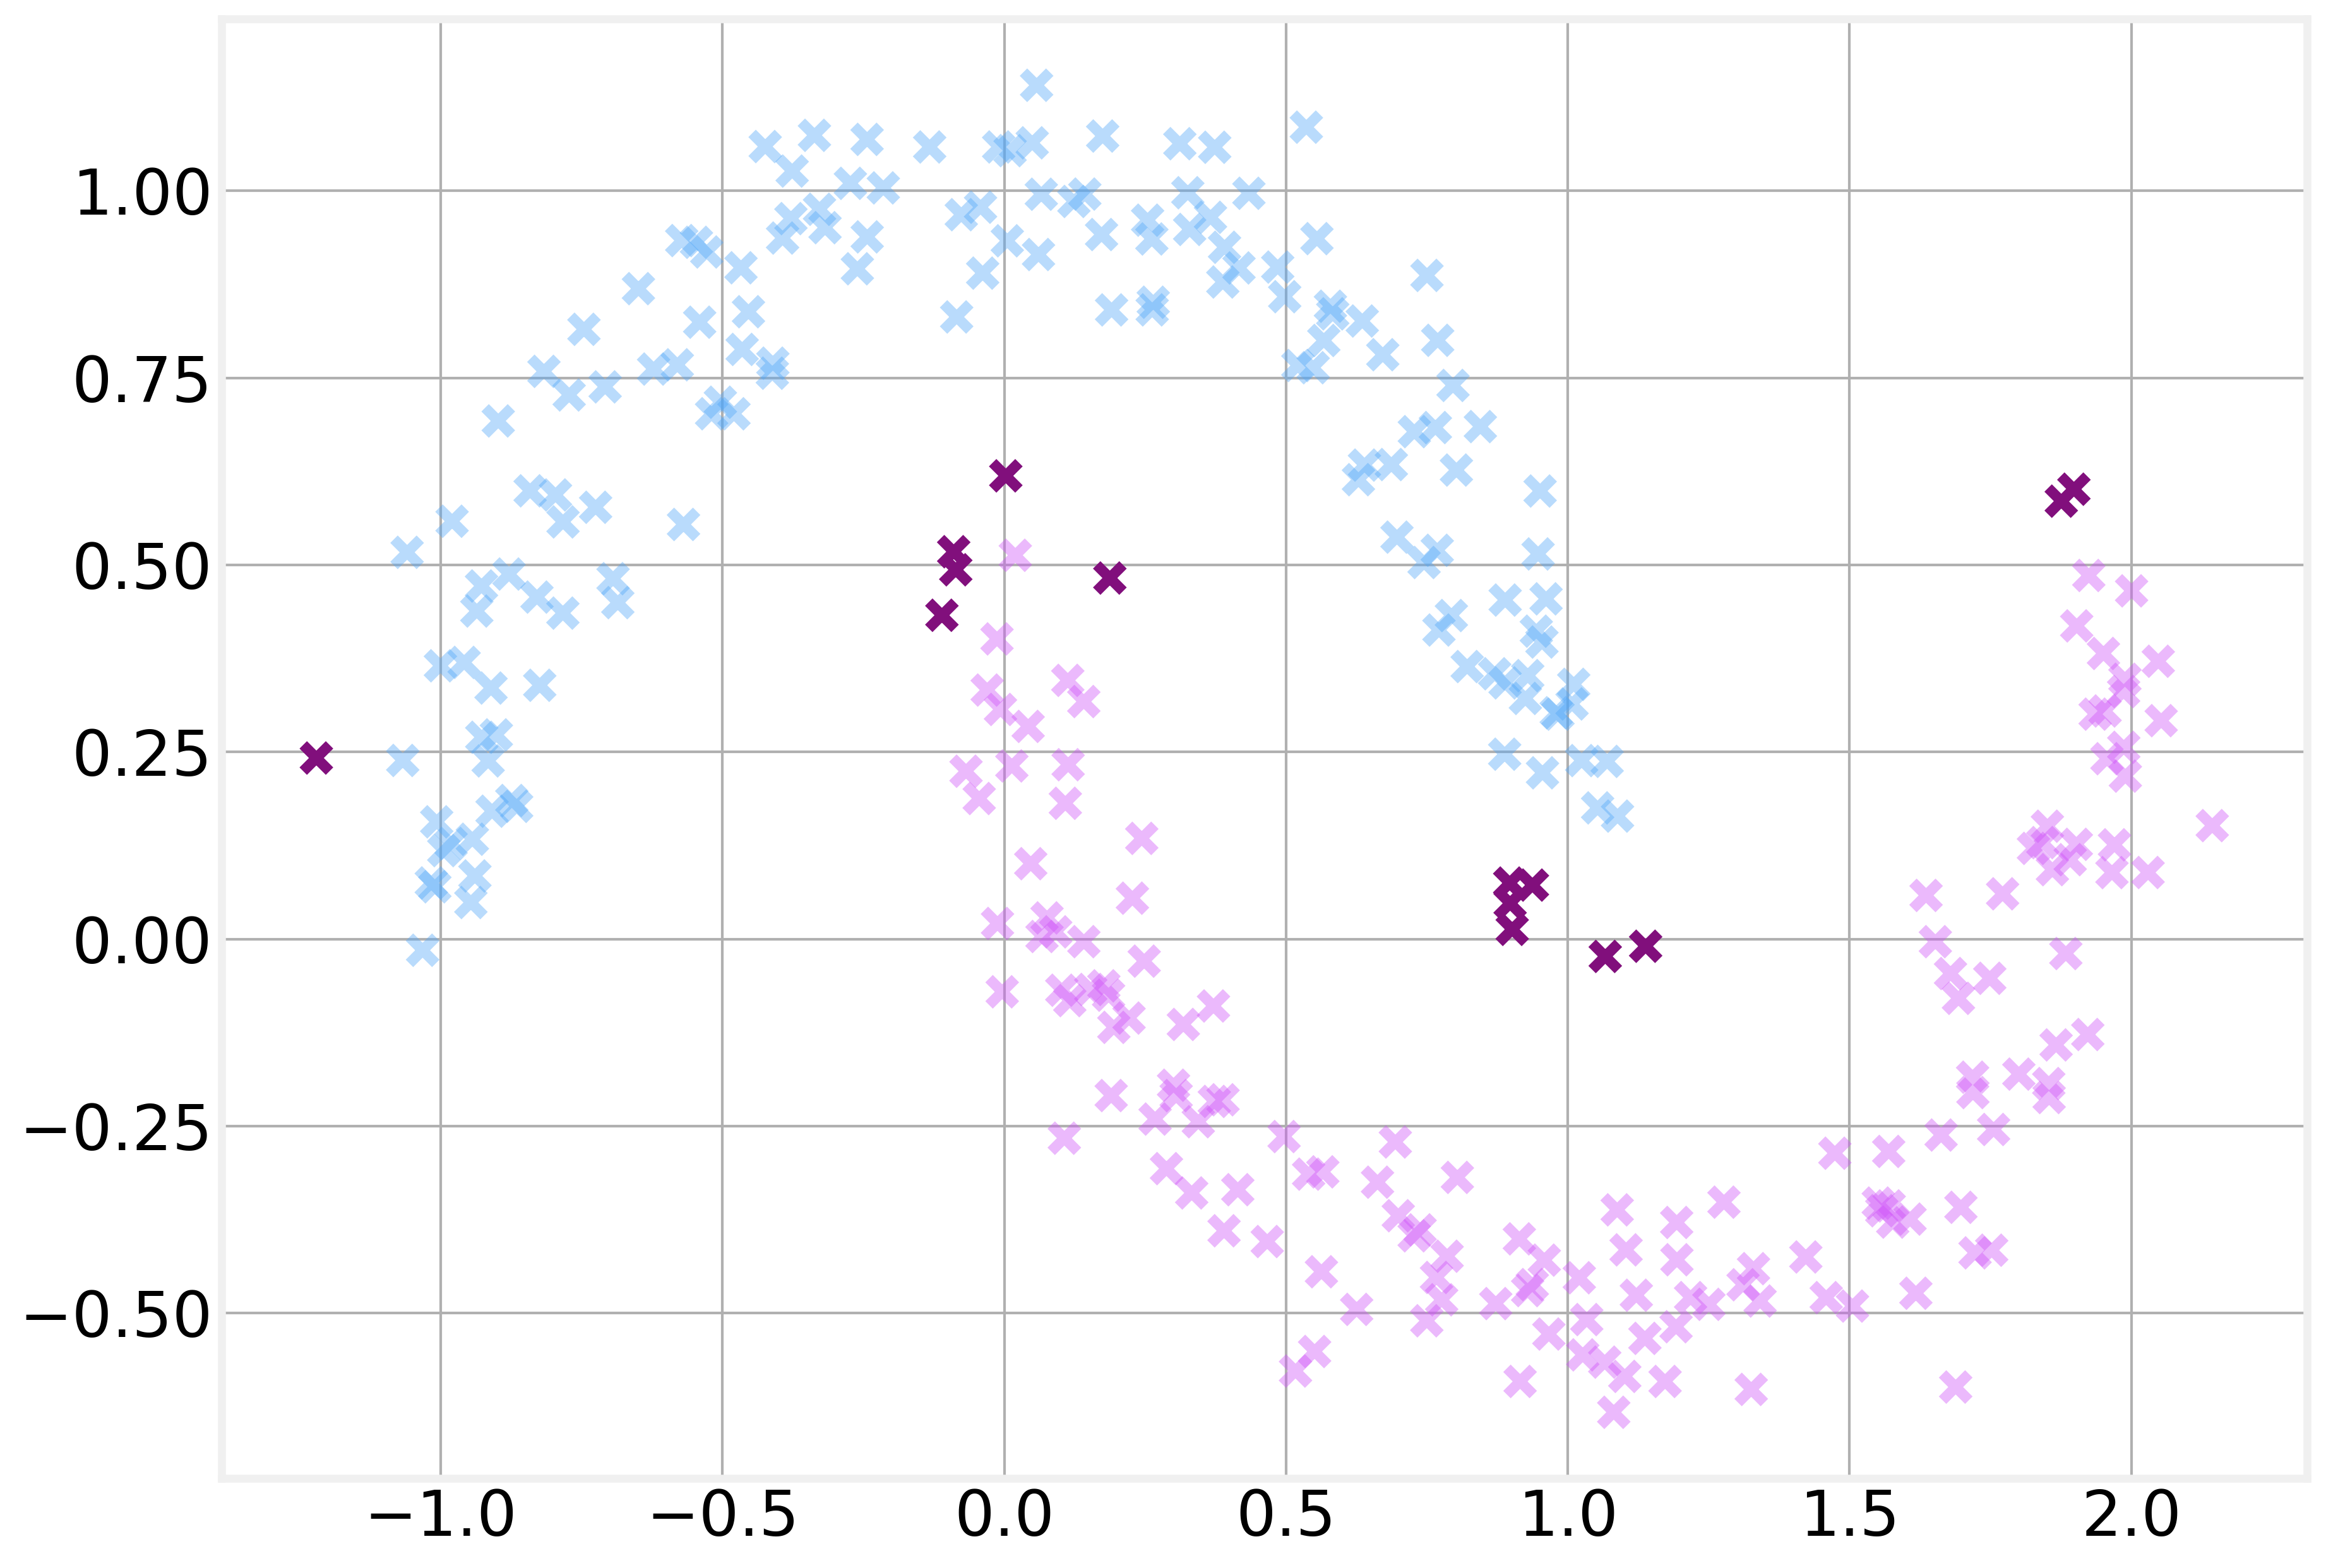

In [26]:
fig, ax = plt.subplots(1)
ax.scatter(moons.T[0][labels>=0], moons.T[1][labels>=0], s=100, c=np.array(colors)[labels[labels>=0]], marker='x', alpha=0.4)
ax.scatter(moons.T[0][labels<0], moons.T[1][labels<0], s=100, c=np.array(colors)[labels[labels<0]], marker='x')

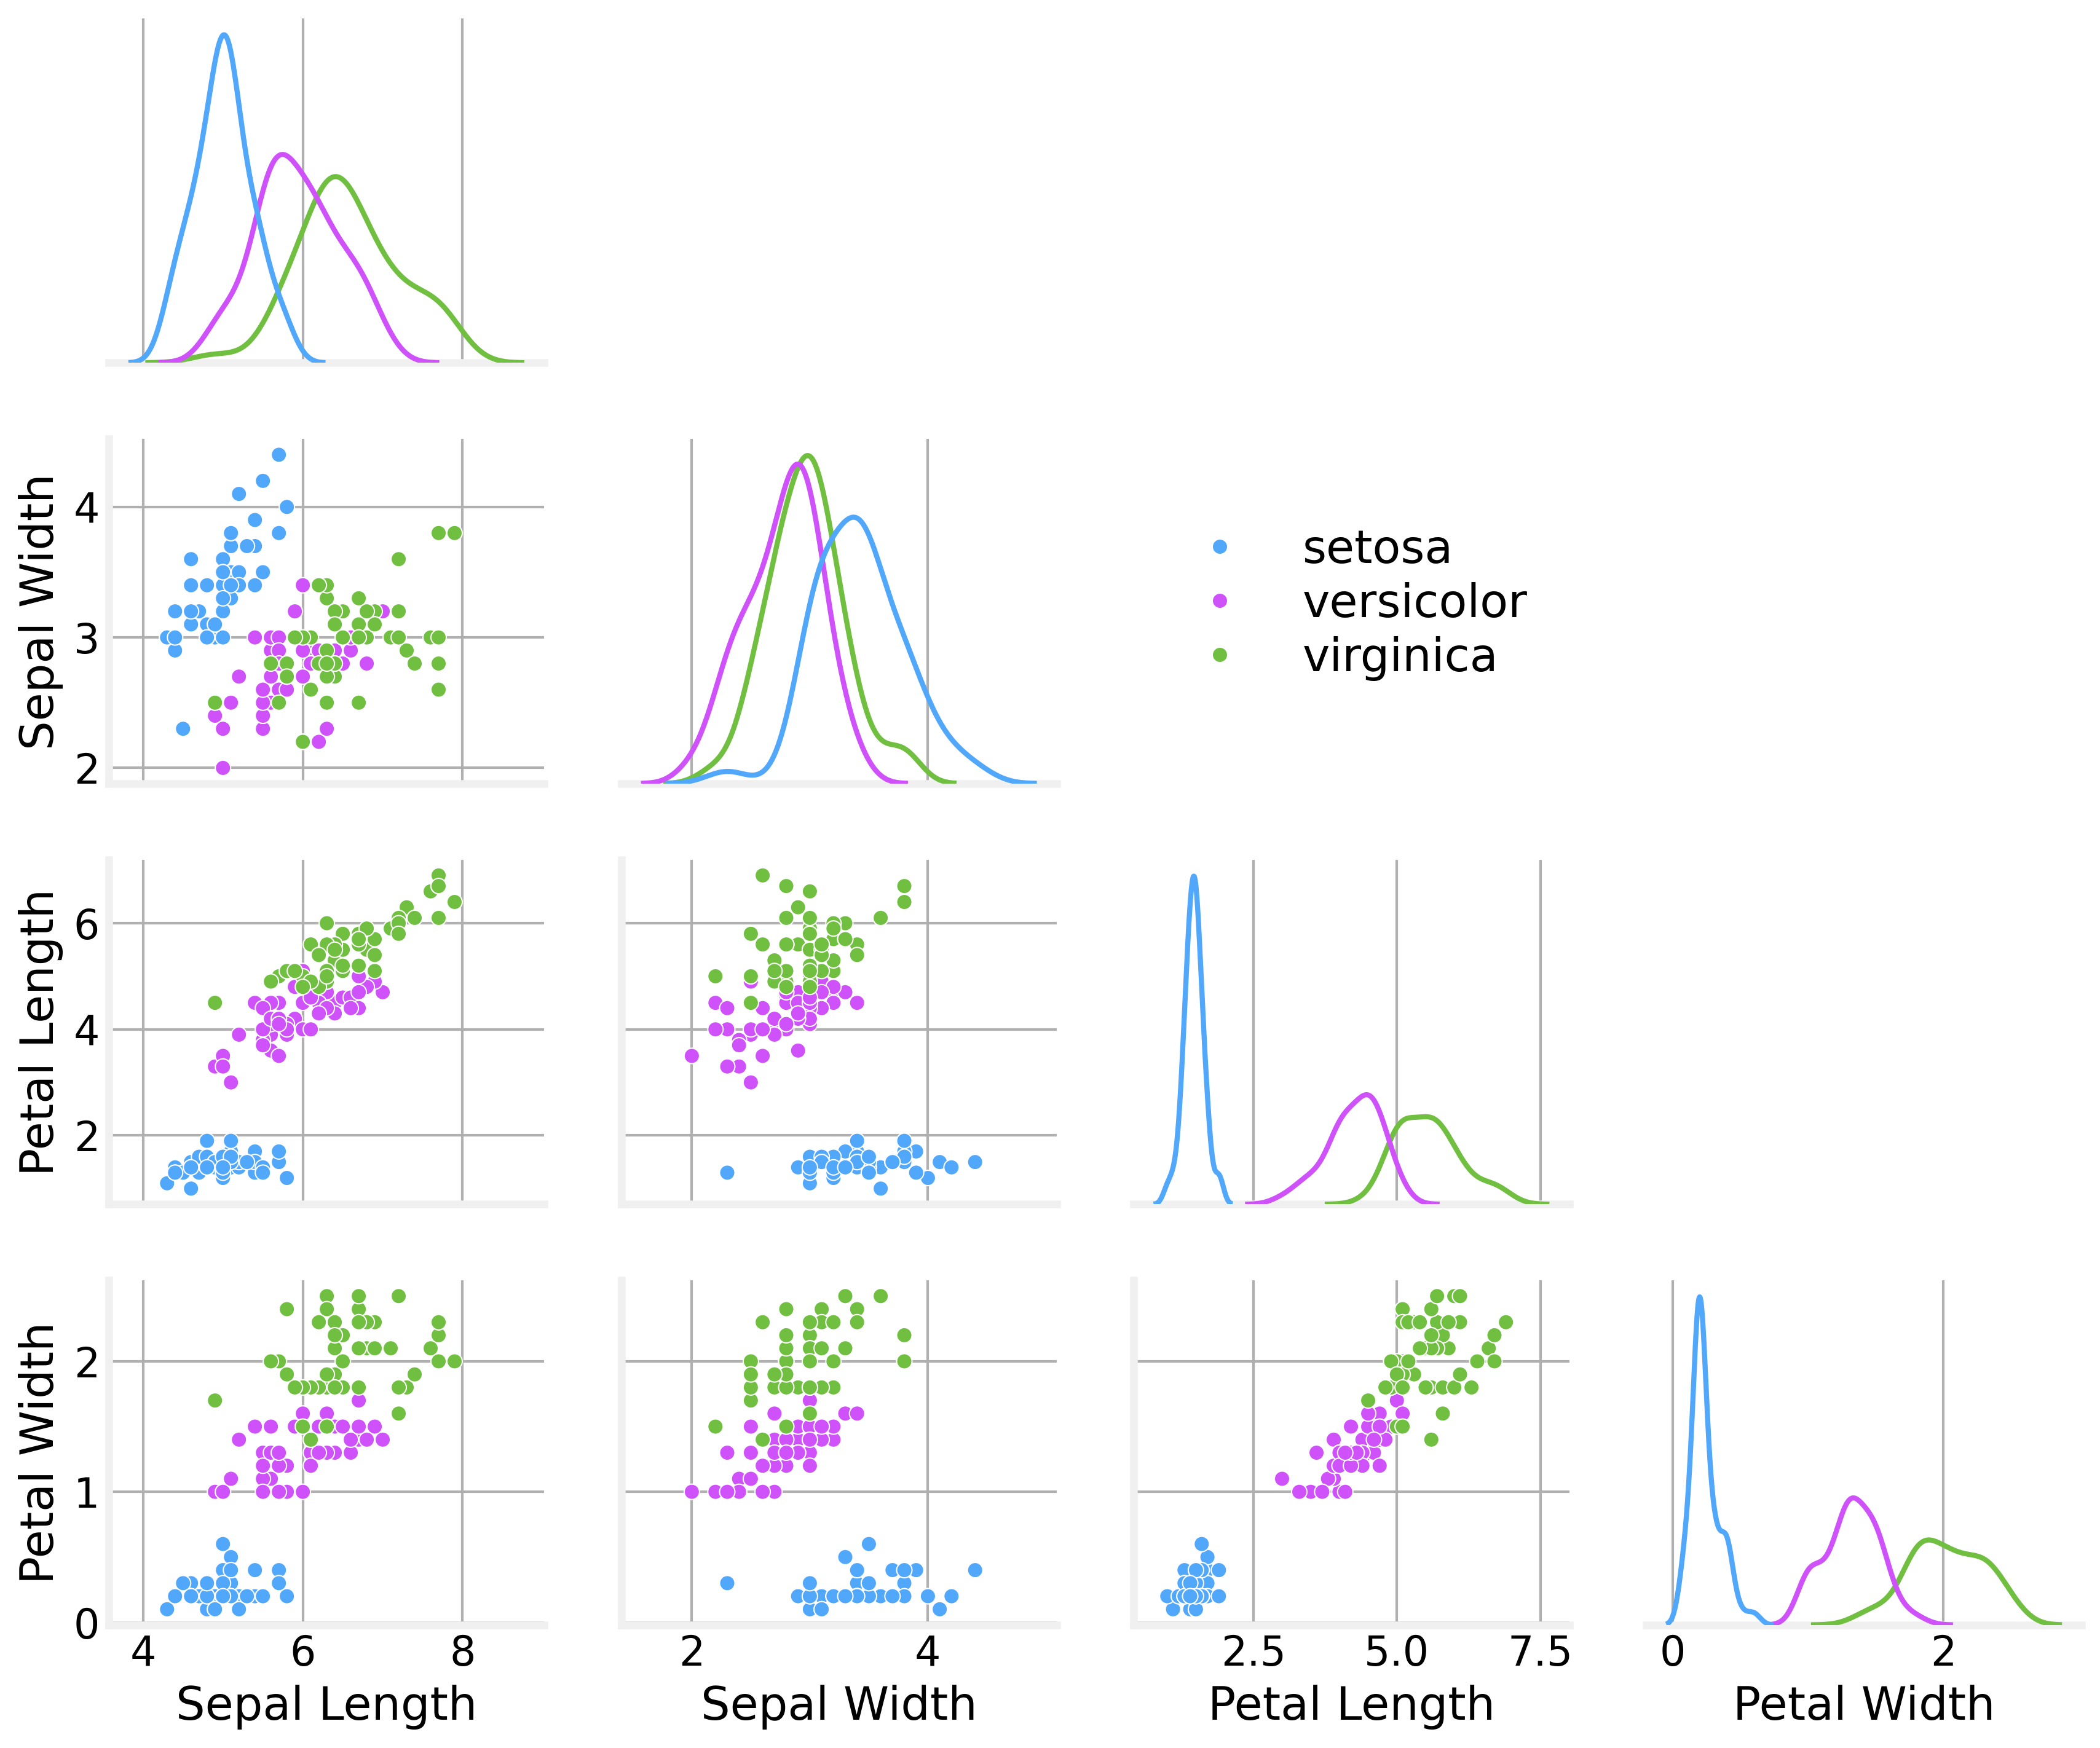

In [28]:
iris = pd.read_csv('data/iris.csv')

pp = sns.PairGrid(iris, diag_sharey=False,  hue='species', corner=True)
pp.map_lower(sns.scatterplot)
pp.map_diag(sns.kdeplot, lw=2)

pp.tick_params(axis='both', labelsize=16)

for ax in pp.axes.flat:
        if ax is not None:
            ax.set_xlabel(" ".join(ax.get_xlabel().split('_')).title(), fontsize=18)
            ax.set_ylabel(" ".join(ax.get_ylabel().split('_')).title(), fontsize=18)

pp.add_legend(title="",fontsize=18, loc=(0.55, 0.6), labelspacing=0.2)

fig = plt.gcf()
fig.tight_layout()

<center>
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" border="0" width=300px> 
</center>